In [1]:
#!pip install nb_black

In [2]:
#%load_ext nb_black

# QRM First Assignment

#### Discussion Box (Keep track of resolved issues here, will delete later)

**Questions so far:**
1. What is the difference between Close and Adj. Close? Which to use?
2. np.log is used for natural logarithm, right?
(Natural logarithm, element-wise. --copied from documentation page)

**Close price adjusted for splits.** 
<br>
''The closing price of a stock is the price of that stock at the close of the trading day.''


**Adjusted close price adjusted for both dividends and splits.**
<br>
''The adjusted closing price is a more complex analysis that uses the closing price as a starting point, but it takes into account factors such as dividends, stock splits and new stock offerings to determine a value. The adjusted closing price represents a more accurate reflection of a stock's value, since distributions and new offerings can alter the closing price.''

So I think in the sense of these dataset, the close price is also a kind of adjusted price since it is adjusted for splits.<br>
I personally would think the adjusted close price (both div and splits) would be better since it's more accurate.

**Discussion:**
**1. Drop the 20 rows for N225 dataset?** <br>
AM: Correct and we need to synchronise with the rest of the data by only considering days where an observation is available for all risk factors <br>
**2. The DE_1YBOND attribute doesn't match with other 4, will the attribute affect the analysis? If not then we can keep them** <br>
AM: This is because the first 4 datasets are from Yahoo data and this one is from another source. It's not a problem as long as we can merge it by Date to the rest of the data.<br>
**3. There would defo some outliers in the data, we shoud decide how to deal with them.**<br>
AM: Good question, let's ask Svetlana and Sarah.

**09.04 AM:**
   1. I think that trying with 2 datasets should happen in a bit different way  ((done))
   2. Isolate the columns of adj. price for each asset and give them clear names to which asset they belong ((done))
   3. Perform a join with on the Date variable (I think the concat function is not doing the job here) ((done))

**11.04 Pan:** I fixed the above probelms.

##### I suggest to keep log of our Methodology and Questions and write email to Svetlana/Sarah next week to verify and ask - do you agree?

**Methodology**
1. Create lags for each individual asset and compute individual asset returns
2. Merge the individual asset datasets and compute portfolio returns and portfolio standard deviation

**Questions**
1. How to deal with unmatching data (i.e. there is obs. for a particular dataset for one asset but none for another asset?). Should we delete all observations for that date altogether? How do we deal with the gap in history? <br>
**Pan:** I took the intersection dates of all five assets. 
I am not sure if it is proper but this is the best we can do so far. <br>
We can ask them!!

2. How to deal with outliers? <br>
**Pan:** The data looks normal so outlier doesn't seem to be a big probelm, but maybe it would affect <br>
when adding the bond. Let's ask as well!

##### Question: My code above looks ugly as I am doing the operations for each dataset separately instead of using some kind of loop to iterate. Can we, please, set up a short call so you can teach me how to do the iteration? :D I will appreciate some CS help! 

**Pan:** Sure, I also took some time to make it into function. <br>
You can have a look and if you don't know some parts, we can have a call :D

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import norm
import scipy as sc
import glob
import matplotlib.pyplot as plt
import os

# from arch import arch_model
# from fnGARCH_2 import *

## Exploratory Data Analysis

In [2]:
"""Import data"""
BTC = pd.read_csv("01_Data/BTCUSD.csv",)
DBC = pd.read_csv("01_Data/DBC.csv")
GSPC = pd.read_csv("01_Data/GSPC.csv")
N225 = pd.read_csv("01_Data/N225.csv")
DE_1YBOND = pd.read_csv("01_Data/DE_1YBOND.csv")
FX_YEN = pd.read_csv("01_Data/JPYUSD=X.csv")
FX_EUR = pd.read_csv("01_Data/EURUSD=X.csv")


"""Check format of the datasets"""
# print(BTC.shape)
# print(DBC.shape)
# print(DE_1YBOND.shape)
# print(GSPC.shape)
# print(N225.shape)
#print(FX_YEN.shape)
#print(FX_EUR.shape)

"""The attribute format of DE bond is different from others"""
# DE_1YBOND.head()
#print(FX_YEN.head())

"""Check if there is null or empty input for any of the datasets."""
# N225.isnull().sum()
# BTC.isnull().sum()
# DBC.isnull().sum()
# GSPC.isnull().sum()
# DE_1YBOND.isnull().sum()
#print(FX_YEN.isnull().sum())
#print(FX_EUR.isnull().sum())

"""N225 has 20 missing values"""
# missing_N225 = N225[N225.isna().any(axis=1)]['Date']
# print(len(N225[N225.isna().any(axis=1)]))
# print(missing_N225)

'N225 has 20 missing values'

**EDA shows 2 issues:**
<br>
1. The attribute format of the bond is different from the stocks
<br>
2. N225 contains 20 missing values, which need to be dropped

In [3]:
""" Change the date format of DE_1YBOND"""
from datetime import datetime

new_date = []
for i in DE_1YBOND["Date"]:
    new = datetime.strptime(i, "%b %d, %Y").strftime("%Y-%m-%d")
    new_date.append(new)

DE_1YBOND["Date"] = new_date

In [4]:
""" Drop the rows which contains missing value in N225"""
N225_drop = N225.dropna(axis=0)
N225_drop = N225_drop.reset_index(drop=True)
print(len(N225_drop))
# N225_drop.isnull().sum()

2205


In [5]:
""" Drop the rows which contains missing value in FX_YEN"""
FX_YEN_drop = FX_YEN.dropna(axis=0)
FX_YEN_drop = FX_YEN_drop.reset_index(drop=True)

""" Drop the rows which contains missing value in FX_EUR"""
FX_EUR_drop = FX_EUR.dropna(axis=0)
FX_EUR_drop = FX_EUR_drop.reset_index(drop=True)

print(len(FX_YEN_drop))
print(len(FX_EUR_drop))

2344
2344


## Data Processing

### 1. Merge data

In [6]:
s1 = set(GSPC["Date"])
s2 = set(DBC["Date"])
s3 = set(N225_drop["Date"])
s4 = set(BTC["Date"])
s5 = set(DE_1YBOND["Date"])
s6 = set(FX_YEN_drop["Date"])
s7 = set(FX_EUR_drop["Date"])

d = [
    x for x in s3 if x in s1 and x in s2 and x in s4 and x in s5 and x in s6 and x in s7
]

asset = [s1, s2, s3, s4, s5, s6, s7]

intersec = s3.intersection(s1, s2, s4, s5, s6, s7)
print(len(intersec))
print(len(d))
set(d) == set(intersec)

print("The dates exist in all five dataset: 2112 trading days")

2112
2112
The dates exist in all five dataset: 2112 trading days


In [7]:
"""  Create new dataframes, keep only the overlapping date-related data"""

new = []
asset = [BTC, DBC, DE_1YBOND, GSPC, N225_drop, FX_YEN_drop, FX_EUR_drop]
for item in asset:
    miss = []
    for i in item["Date"]:
        if i not in intersec:
            miss = miss + item.index[item["Date"] == i].tolist()
    item = item.drop(miss)
    item = item.reset_index(drop=True)
    new.append(item)

In [8]:
""" Assign the dataframe """

BTC_new = new[0]
DBC_new = new[1]
DE_1YBOND_new = new[2]
GSPC_new = new[3]
N225_new = new[4]
FX_YEN_new = new[5]
FX_EUR_new = new[6]

asset = [BTC_new, DBC_new, DE_1YBOND_new, GSPC_new, N225_new, FX_YEN_new, FX_EUR_new]

for i in asset:
    print(i.shape)
    print(i.isnull().sum())

(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2112, 6)
Date        0
Price       0
Open        0
High        0
Low         0
Change %    0
dtype: int64
(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [9]:
DE_1YBOND_new.head()

,Date,Price,Open,High,Low,Change %
0,2020-03-30,-0.689,-0.685,-0.658,-0.881,-1.85%
1,2020-03-27,-0.702,-0.626,-0.600,-0.920,14.89%
2,2020-03-26,-0.611,-0.645,-0.562,-0.679,-3.63%
3,2020-03-25,-0.634,-0.615,-0.557,-0.674,4.97%
4,2020-03-24,-0.604,-0.678,-0.600,-0.723,-12.21%


In [9]:
""" Process German Bonds data to match the format of the rest of the datasets """
"""Rename Columns"""
DE_1YBOND_new.rename(columns={"Price": "Adj Close"}, inplace=True)
"""Sort Data"""
DE_1YBOND_new = DE_1YBOND_new.sort_values(by=["Date"]).reset_index(drop=True)

In [12]:
DE_1YBOND_new.head()

,Date,Adj Close,Open,High,Low,Change %
0,2011-03-31,1.209,1.209,1.209,1.209,2.28%
1,2011-04-01,1.306,1.306,1.306,1.306,8.02%
2,2011-04-04,1.292,1.292,1.292,1.292,-1.07%
3,2011-04-05,1.299,1.299,1.299,1.299,0.54%
4,2011-04-06,1.294,1.294,1.294,1.294,-0.38%


In [10]:
###SANDBOX


""" Create new dataframe containing only the same dates related information  """

# asset_price , asset_adj_price , return

asset = [DE_1YBOND_new, BTC_new, DBC_new, GSPC_new, N225_new, FX_YEN_new, FX_EUR_new]
asset_name = ["DE_1YBOND", "BTC", "DBC", "GSPC", "N225", "FX_YEN", "FX_EUR"]

for i in range(len(asset)):
    """Rename Price column"""
    asset[i].rename(columns={"Adj Close": "Price_" + asset_name[i]}, inplace=True)
    """Create lags for all assets"""
    asset[i]["Price_" + asset_name[i] + "_lag"] = asset[i][
        "Price_" + asset_name[i]
    ].shift(1)
    """Calculate individual asset returns"""
    # Bonds - simple difference between current and lagged value; Stocks - log return
    if i == 0:
        asset[i][asset_name[i] + "_return"] = (
            asset[i]["Price_" + asset_name[i]]
            - asset[i]["Price_" + asset_name[i] + "_lag"]
        )
    else:
        asset[i][asset_name[i] + "_return"] = np.log(
            asset[i]["Price_" + asset_name[i]]
            / asset[i]["Price_" + asset_name[i] + "_lag"]
        )

    # Create stressed equity prices - that's some horrible coding in here
    asset[i]["Price_" + asset_name[i] + "_plus20"] = (
        asset[i]["Price_" + asset_name[i]] * 1.2
    )
    asset[i]["Price_" + asset_name[i] + "_plus40"] = (
        asset[i]["Price_" + asset_name[i]] * 1.4
    )
    asset[i]["Price_" + asset_name[i] + "_minus20"] = (
        asset[i]["Price_" + asset_name[i]] * 0.8
    )
    asset[i]["Price_" + asset_name[i] + "_minus40"] = (
        asset[i]["Price_" + asset_name[i]] * 0.6
    )

    # Create stressed returns
    asset[i]["Price_" + asset_name[i] + "_plus20_lag"] = asset[i][
        "Price_" + asset_name[i]
    ].shift(1)
    asset[i]["Price_" + asset_name[i] + "_plus40_lag"] = asset[i][
        "Price_" + asset_name[i]
    ].shift(1)
    asset[i]["Price_" + asset_name[i] + "_minus20_lag"] = asset[i][
        "Price_" + asset_name[i]
    ].shift(1)
    asset[i]["Price_" + asset_name[i] + "_minus40_lag"] = asset[i][
        "Price_" + asset_name[i]
    ].shift(1)

    if i == 0:
        asset[i][asset_name[i] + "_plus20" + "_return"] = (
            asset[i]["Price_" + asset_name[i] + "_plus20"]
            - asset[i]["Price_" + asset_name[i] + "_plus20_lag"]
        )
        asset[i][asset_name[i] + "_plus40" + "_return"] = (
            asset[i]["Price_" + asset_name[i] + "_plus40"]
            - asset[i]["Price_" + asset_name[i] + "_plus40_lag"]
        )
        asset[i][asset_name[i] + "_minus20" + "_return"] = (
            asset[i]["Price_" + asset_name[i] + "_minus20"]
            - asset[i]["Price_" + asset_name[i] + "_minus20_lag"]
        )
        asset[i][asset_name[i] + "_minus40" + "_return"] = (
            asset[i]["Price_" + asset_name[i] + "_minus40"]
            - asset[i]["Price_" + asset_name[i] + "_minus40_lag"]
        )
    else:
        asset[i][asset_name[i] + "_plus20" + "_return"] = np.log(
            asset[i]["Price_" + asset_name[i] + "_plus20"]
            / asset[i]["Price_" + asset_name[i] + "_plus20_lag"]
        )
        asset[i][asset_name[i] + "_plus40" + "_return"] = np.log(
            asset[i]["Price_" + asset_name[i] + "_plus40"]
            / asset[i]["Price_" + asset_name[i] + "_plus40_lag"]
        )
        asset[i][asset_name[i] + "_minus20" + "_return"] = np.log(
            asset[i]["Price_" + asset_name[i] + "_minus20"]
            / asset[i]["Price_" + asset_name[i] + "_minus20_lag"]
        )
        asset[i][asset_name[i] + "_minus40" + "_return"] = np.log(
            asset[i]["Price_" + asset_name[i] + "_minus40"]
            / asset[i]["Price_" + asset_name[i] + "_minus40_lag"]
        )


print(DE_1YBOND_new)

            Date  Price_DE_1YBOND   Open   High    Low Change %  \
0     2011-03-31            1.209  1.209  1.209  1.209    2.28%   
1     2011-04-01            1.306  1.306  1.306  1.306    8.02%   
2     2011-04-04            1.292  1.292  1.292  1.292   -1.07%   
3     2011-04-05            1.299  1.299  1.299  1.299    0.54%   
4     2011-04-06            1.294  1.294  1.294  1.294   -0.38%   
...          ...              ...    ...    ...    ...      ...   
2107  2020-03-24           -0.604 -0.678 -0.600 -0.723  -12.21%   
2108  2020-03-25           -0.634 -0.615 -0.557 -0.674    4.97%   
2109  2020-03-26           -0.611 -0.645 -0.562 -0.679   -3.63%   
2110  2020-03-27           -0.702 -0.626 -0.600 -0.920   14.89%   
2111  2020-03-30           -0.689 -0.685 -0.658 -0.881   -1.85%   

      Price_DE_1YBOND_lag  DE_1YBOND_return  Price_DE_1YBOND_plus20  \
0                     NaN               NaN                  1.4508   
1                   1.209             0.097          

In [11]:
# Keep only relevant columns

result = []
for i in range(len(asset)):
    print(asset_name[i])
    if i == 0:
        asset[i] = asset[i][
            [
                "Date",
                "Price_" + asset_name[i],
                "Price_" + asset_name[i] + "_lag",
                asset_name[i] + "_return",
                asset_name[i] + "_plus20" + "_return",
                asset_name[i] + "_plus40" + "_return",
                asset_name[i] + "_minus20" + "_return",
                asset_name[i] + "_minus40" + "_return",
            ]
        ]
        result.append(asset[i])
    else:
        asset[i] = asset[i][
            [
                "Price_" + asset_name[i],
                "Price_" + asset_name[i] + "_lag",
                asset_name[i] + "_return",
                asset_name[i] + "_plus20" + "_return",
                asset_name[i] + "_plus40" + "_return",
                asset_name[i] + "_minus20" + "_return",
                asset_name[i] + "_minus40" + "_return",
            ]
        ]
        result.append(asset[i])

DE_1YBOND
BTC
DBC
GSPC
N225
FX_YEN
FX_EUR


In [12]:
# Check the shape
BTC_new = result[1]
DBC_new = result[2]
DE_1YBOND_new = result[0]
GSPC_new = result[3]
N225_new = result[4]
FX_YEN_new = result[5]
FX_EUR_new = result[6]


asset = [BTC_new,DBC_new, DE_1YBOND_new, GSPC_new,N225_new,FX_YEN_new,FX_EUR_new]


for i in asset:
    print(i.shape)


(2112, 7)
(2112, 7)
(2112, 8)
(2112, 7)
(2112, 7)
(2112, 7)
(2112, 7)


In [13]:
print(N225_new["N225_return"].head())
print(FX_YEN_new["FX_YEN_return"].head())

0         NaN
1   -0.004800
2    0.001081
3   -0.010690
4   -0.003248
Name: N225_return, dtype: float64
0         NaN
1   -0.002498
2   -0.010222
3    0.001010
4   -0.012104
Name: FX_YEN_return, dtype: float64


In [14]:
''' Add the Nikkei return and FX_YUAN together as one total N225 return'''

N225_new['N225_return_all']  = N225_new['N225_return']  + FX_YEN_new['FX_YEN_return'] 
N225_new = N225_new.drop(['N225_return'],axis=1)
N225_new.rename(columns={'N225_return_all':'N225_return'}, inplace=True)


/home/isualice/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
N225_new

,Price_N225,Price_N225_lag,N225_plus20_return,N225_plus40_return,N225_minus20_return,N225_minus40_return,N225_return
0,9755.099609,NaN,NaN,NaN,NaN,NaN,NaN
1,9708.389648,9755.099609,0.177522,0.331672,-0.227943,-0.515625,-0.007297
2,9718.889648,9708.389648,0.183403,0.337553,-0.222063,-0.509745,-0.009141
3,9615.549805,9718.889648,0.171632,0.325782,-0.233833,-0.521515,-0.009680
4,9584.370117,9615.549805,0.179074,0.333224,-0.226391,-0.514074,-0.015352
...,...,...,...,...,...,...,...
2107,18092.349609,16887.779297,0.251220,0.405371,-0.154245,-0.441927,0.065580
2108,19546.630859,18092.349609,0.259635,0.413786,-0.145830,-0.433512,0.074650
2109,18664.599609,19546.630859,0.136147,0.290298,-0.269318,-0.557000,-0.043954
2110,19389.429688,18664.599609,0.220421,0.374572,-0.185044,-0.472726,0.054158


In [15]:
"""And drop FX_YEN and FX_EUR from the list """
asset = [BTC_new, DBC_new, GSPC_new, N225_new, DE_1YBOND_new, FX_YEN_new, FX_EUR_new]

asset = asset[:-2]
print(asset)

[        Price_BTC  Price_BTC_lag  BTC_return  BTC_plus20_return  \
0        0.784600            NaN         NaN                NaN   
1        0.774100       0.784600   -0.013473           0.168849   
2        0.680000       0.774100   -0.129608           0.052713   
3        0.710000       0.680000    0.043172           0.225494   
4        0.740000       0.710000    0.041385           0.223707   
...           ...            ...         ...                ...   
2107  6734.804688    6416.314941    0.048445           0.230766   
2108  6681.062500    6734.804688   -0.008012           0.174310   
2109  6716.439941    6681.062500    0.005281           0.187603   
2110  6469.799316    6716.439941   -0.037413           0.144908   
2111  6441.589355    6469.799316   -0.004370           0.177952   

      BTC_plus40_return  BTC_minus20_return  BTC_minus40_return  
0                   NaN                 NaN                 NaN  
1              0.322999           -0.236617           -0.52429

In [18]:
asset[-1]

,Date,Price_DE_1YBOND,Price_DE_1YBOND_lag,DE_1YBOND_return,DE_1YBOND_plus20_return,DE_1YBOND_plus40_return,DE_1YBOND_minus20_return,DE_1YBOND_minus40_return
0,2011-03-31,1.209,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-04-01,1.306,1.209,0.097,0.3582,0.6194,-0.1642,-0.4254
2,2011-04-04,1.292,1.306,-0.014,0.2444,0.5028,-0.2724,-0.5308
3,2011-04-05,1.299,1.292,0.007,0.2668,0.5266,-0.2528,-0.5126
4,2011-04-06,1.294,1.299,-0.005,0.2538,0.5126,-0.2638,-0.5226
...,...,...,...,...,...,...,...,...
2107,2020-03-24,-0.604,-0.688,0.084,-0.0368,-0.1576,0.2048,0.3256
2108,2020-03-25,-0.634,-0.604,-0.030,-0.1568,-0.2836,0.0968,0.2236
2109,2020-03-26,-0.611,-0.634,0.023,-0.0992,-0.2214,0.1452,0.2674
2110,2020-03-27,-0.702,-0.611,-0.091,-0.2314,-0.3718,0.0494,0.1898


In [16]:
# Merge
asset = [DE_1YBOND_new,BTC_new, DBC_new, GSPC_new, N225_new]
data = pd.concat(asset, axis=1)
data.head()

,Date,Price_DE_1YBOND,Price_DE_1YBOND_lag,DE_1YBOND_return,DE_1YBOND_plus20_return,DE_1YBOND_plus40_return,DE_1YBOND_minus20_return,DE_1YBOND_minus40_return,Price_BTC,Price_BTC_lag,...,GSPC_plus40_return,GSPC_minus20_return,GSPC_minus40_return,Price_N225,Price_N225_lag,N225_plus20_return,N225_plus40_return,N225_minus20_return,N225_minus40_return,N225_return
0,2011-03-31,1.209,NaN,NaN,NaN,NaN,NaN,NaN,0.7846,NaN,...,NaN,NaN,NaN,9755.099609,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-04-01,1.306,1.209,0.097,0.3582,0.6194,-0.1642,-0.4254,0.7741,0.7846,...,0.341423,-0.218193,-0.505875,9708.389648,9755.099609,0.177522,0.331672,-0.227943,-0.515625,-0.007297
2,2011-04-04,1.292,1.306,-0.014,0.2444,0.5028,-0.2724,-0.5308,0.6800,0.7741,...,0.336817,-0.222798,-0.510480,9718.889648,9708.389648,0.183403,0.337553,-0.222063,-0.509745,-0.009141
3,2011-04-05,1.299,1.292,0.007,0.2668,0.5266,-0.2528,-0.5126,0.7100,0.6800,...,0.336292,-0.223324,-0.511006,9615.549805,9718.889648,0.171632,0.325782,-0.233833,-0.521515,-0.009680
4,2011-04-06,1.294,1.299,-0.005,0.2538,0.5126,-0.2638,-0.5226,0.7400,0.7100,...,0.338654,-0.220962,-0.508644,9584.370117,9615.549805,0.179074,0.333224,-0.226391,-0.514074,-0.015352


### 2. Calculate portfolio returns (with and without Stress)

In [17]:
"""Assume equal weight (0.20) for the 5 assets and calculate portfolio returns - later to change it when we also add the bond"""

data["portfolio_return"] = (
    0.20 * data["BTC_return"]
    + 0.20 * data["DBC_return"]
    + 0.20 * data["GSPC_return"]
    + 0.20 * data["N225_return"]
    + 0.20 * data["DE_1YBOND_return"]
)
data["portfolio_return_plus20"] = (
    0.20 * data["BTC_plus20_return"]
    + 0.20 * data["DBC_plus20_return"]
    + 0.20 * data["GSPC_plus20_return"]
    + 0.20 * data["N225_plus20_return"]
    + 0.20 * data["DE_1YBOND_plus20_return"]
)
data["portfolio_return_plus40"] = (
    0.20 * data["BTC_plus40_return"]
    + 0.20 * data["DBC_plus40_return"]
    + 0.20 * data["GSPC_plus40_return"]
    + 0.20 * data["N225_plus40_return"]
    + 0.20 * data["DE_1YBOND_plus40_return"]
)
data["portfolio_return_minus20"] = (
    0.20 * data["BTC_minus20_return"]
    + 0.20 * data["DBC_minus20_return"]
    + 0.20 * data["GSPC_minus20_return"]
    + 0.20 * data["N225_minus20_return"]
    + 0.20 * data["DE_1YBOND_minus20_return"]
)
data["portfolio_return_minus40"] = (
    0.20 * data["BTC_minus40_return"]
    + 0.20 * data["DBC_minus40_return"]
    + 0.20 * data["GSPC_minus40_return"]
    + 0.20 * data["N225_minus40_return"]
    + 0.20 * data["DE_1YBOND_minus40_return"]
)

In [18]:
number = [0,500,1000,1500,2000]
dates = []
for i in number:
    print(data.Date[i])
    dates.append(data.Date[i])


2011-03-31
2013-05-20
2015-07-09
2017-08-21
2019-10-04


In [19]:
print(dates)

['2011-03-31', '2013-05-20', '2015-07-09', '2017-08-21', '2019-10-04']


[-500.    0.  500. 1000. 1500. 2000. 2500.]


Text(0, 0.5, 'Average portfolio return')

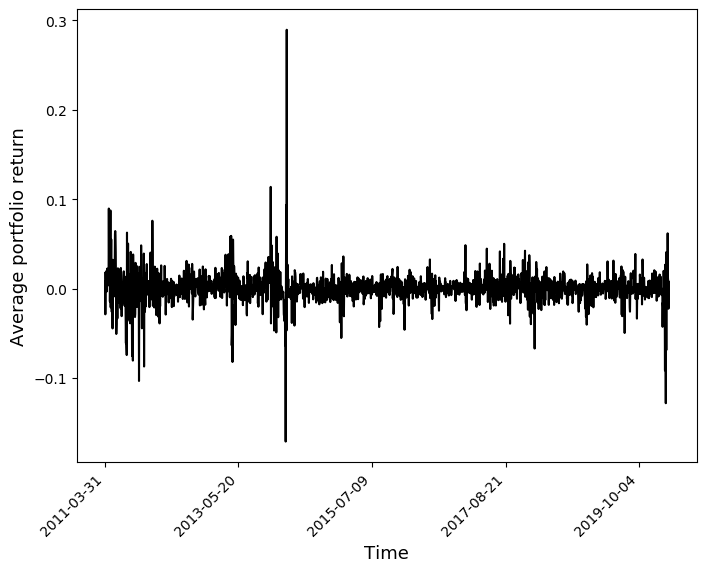

In [20]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(data['portfolio_return'],'k')
locs, labels=plt.xticks()
print(locs)
x_ticks = []
new_xticks=[dates[i] for d in locs for i in range(5)  ]
plt.xticks(locs[1:-1],new_xticks, rotation=45, horizontalalignment='right')
plt.xlabel("Time", fontsize=13)
plt.ylabel("Average portfolio return", fontsize=13)

### 3. Plots

/home/isualice/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


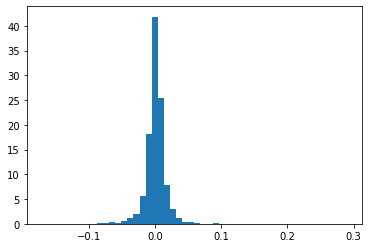

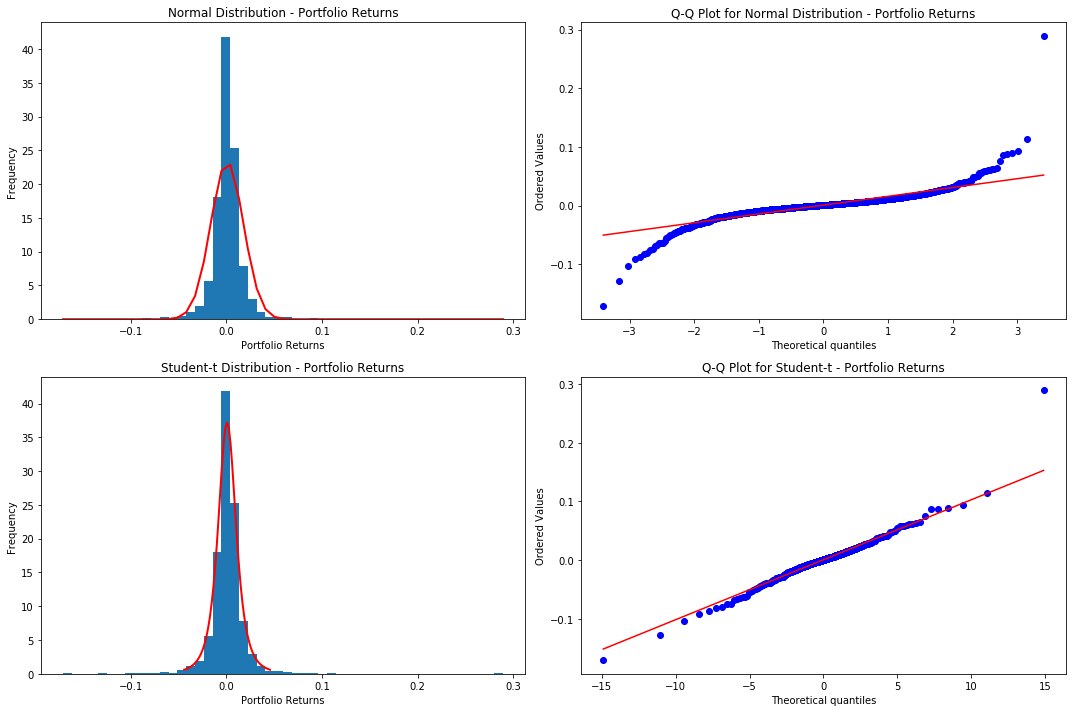

In [21]:
##assign df:
df = 3
# create distributions
mu = np.mean(data["portfolio_return"][1:])
sigma = np.std(data["portfolio_return"][1:])
sigmat = np.sqrt(np.var(data["portfolio_return"][1:]) * (df - 2) / df)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, normed=True)
normaldistr = (
    1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((bins - mu) ** 2) / (2 * sigma ** 2))
)
tval = np.linspace(
    sc.stats.t.ppf(0.01, df, mu, sigmat), sc.stats.t.ppf(0.99, df, mu, sigmat), 51
)
tdistr = sc.stats.t.pdf(tval, df, mu, sigmat)  # Simulate t-distribution
### figure for t distr. and normal distr. comparison
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
# normal
plt.subplot(2, 2, 1)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, density=True)
plt.plot(bins, normaldistr, linewidth=2, color="r")
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")
# plt.xlim( (-40000, 40000) )
plt.title("Normal Distribution - Portfolio Returns")
# normal qq
plt.subplot(2, 2, 2)
sc.stats.probplot(data["portfolio_return"][1:], dist="norm", plot=plt)
plt.title("Q-Q Plot for Normal Distribution - Portfolio Returns")
# stundent t
plt.subplot(2, 2, 3)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, density=True)
plt.plot(tval, tdistr, linewidth=2, color="r")
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")
# plt.xlim( (-40000, 40000) )
plt.title("Student-t Distribution - Portfolio Returns")
# student t qq
plt.subplot(2, 2, 4)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(df), plot=plt)
plt.title("Q-Q Plot for Student-t - Portfolio Returns")
plt.tight_layout()
plt.show()

In [25]:
data

,Date,Price_DE_1YBOND,Price_DE_1YBOND_lag,DE_1YBOND_return,DE_1YBOND_plus20_return,DE_1YBOND_plus40_return,DE_1YBOND_minus20_return,DE_1YBOND_minus40_return,Price_BTC,Price_BTC_lag,...,N225_plus20_return,N225_plus40_return,N225_minus20_return,N225_minus40_return,N225_return,portfolio_return,portfolio_return_plus20,portfolio_return_plus40,portfolio_return_minus20,portfolio_return_minus40
0,2011-03-31,1.209,NaN,NaN,NaN,NaN,NaN,NaN,0.784600,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-04-01,1.306,1.209,0.097,0.3582,0.6194,-0.1642,-0.4254,0.774100,0.784600,...,0.177522,0.331672,-0.227943,-0.515625,-0.007297,0.017608,0.216205,0.391765,-0.212647,-0.495033
2,2011-04-04,1.292,1.306,-0.014,0.2444,0.5028,-0.2724,-0.5308,0.680000,0.774100,...,0.183403,0.337553,-0.222063,-0.509745,-0.009141,-0.028666,0.170915,0.345916,-0.256817,-0.538642
3,2011-04-05,1.299,1.292,0.007,0.2668,0.5266,-0.2528,-0.5126,0.710000,0.680000,...,0.171632,0.325782,-0.233833,-0.521515,-0.009680,0.008256,0.205871,0.381152,-0.222421,-0.504527
4,2011-04-06,1.294,1.299,-0.005,0.2538,0.5126,-0.2638,-0.5226,0.740000,0.710000,...,0.179074,0.333224,-0.226391,-0.514074,-0.015352,0.005222,0.205260,0.380341,-0.222632,-0.504538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,2020-03-24,-0.604,-0.688,0.084,-0.0368,-0.1576,0.2048,0.3256,6734.804688,6416.314941,...,0.251220,0.405371,-0.154245,-0.441927,0.065580,0.061831,0.184192,0.283353,-0.091860,-0.297845
2108,2020-03-25,-0.634,-0.604,-0.030,-0.1568,-0.2836,0.0968,0.2236,6681.062500,6734.804688,...,0.259635,0.413786,-0.145830,-0.433512,0.074650,0.012953,0.133983,0.231944,-0.139669,-0.344454
2109,2020-03-26,-0.611,-0.634,0.023,-0.0992,-0.2214,0.1452,0.2674,6716.439941,6681.062500,...,0.136147,0.290298,-0.269318,-0.557000,-0.043954,0.008277,0.129251,0.228131,-0.146242,-0.351947
2110,2020-03-27,-0.702,-0.611,-0.091,-0.2314,-0.3718,0.0494,0.1898,6469.799316,6716.439941,...,0.220421,0.374572,-0.185044,-0.472726,0.054158,-0.022404,0.092162,0.187402,-0.176050,-0.378116


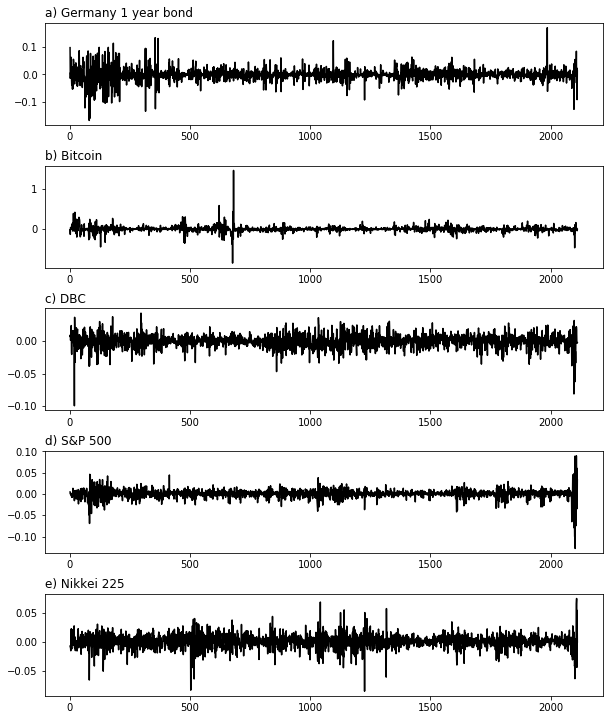

In [22]:
# plot of risk factor returns

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))
# DE_1YBOND
plt.subplot(6, 1, 1)
plt.plot(data["DE_1YBOND_return"][1:], "k")
plt.title("a) Germany 1 year bond", loc="left")
# BTC_return
plt.subplot(6, 1, 2)
plt.plot(data["BTC_return"][1:], "k")
plt.title("b) Bitcoin", loc="left")
# DBC_return
plt.subplot(6, 1, 3)
plt.plot(data["DBC_return"][1:], "k")
plt.title("c) DBC", loc="left")
# GSPC_return
plt.subplot(6, 1, 4)
plt.plot(data["GSPC_return"][1:], "k")
plt.title("d) S&P 500", loc="left")
# N225_return
plt.subplot(6, 1, 5)
plt.plot(data["N225_return"][1:], "k")
plt.title("e) Nikkei 225", loc="left")
plt.subplots_adjust(hspace=0.4)

## VaR and ES

### 1. Normal Distribution

In [23]:
def fnVaR_n(dfData, weights, alpha, lookback, percent, initial_investment):
    """
    purpose:
        calculates VaR and ES with variance-covariance method
        using a normal distribution
    input:
        dfData, dataframe
        weights, weights vector
        alpha, significance value
        lookback, lookback period
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # express years in days
    years = lookback
    # select last n years of data
    DataTemp = dfData.iloc[-years * 250 :, :-1]  # converted to days

    # calculate mean
    mean = np.array(np.mean(DataTemp)) @ weights.T
    mean = mean[0]

    # calculate covariance
    cov = np.cov(DataTemp, rowvar=False)
    # calculate variance
    variance = weights @ cov @ weights.T
    std = np.sqrt(variance[0][0])

    # calculate quantile
    z = sc.stats.norm.ppf(alpha)
    VaR = (
        -mean + z * std
    )  # μ is negative of the return over one day, so should be negative sign
    VaR = -VaR

    mean_return = dfData["portfolio_return"][-years * 250 :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output
    if percent[0] == True:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR * 100, 2),
            "%",
            round(ES * 100, 2),
            "%",
        )
    else:

        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )

    return VaR, ES


In [24]:
# Set an initial investment level
initial_investment = 1000000
lookback = 4

df_prices = data[
    ['DE_1YBOND_return',"BTC_return", "DBC_return", "GSPC_return", "N225_return", "portfolio_return"]
]
weights = np.array([[0.2, 0.2, 0.2, 0.2,0.2]])


fnVaR_n(df_prices, weights, 0.025, lookback, [True,0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.025, lookback, [False,0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.01, lookback, [True,0.99], initial_investment)
fnVaR_n(df_prices, weights, 0.01, lookback, [False,0.99], initial_investment)

( 97.5 %  VaR, ES) in percent is:  2.54 % 4.27 %
( 97.5 %  VaR, ES) in monetary terms is:  25366.75 42710.76
( 99.0 %  VaR, ES) in percent is:  3.0 % 5.15 %
( 99.0 %  VaR, ES) in monetary terms is:  30009.86 51507.44


(0.030009856910766283, 0.051507442581682314)

### Sensitivity analysis

In [113]:
fnVaR_n(df_prices.iloc[:-150,:], weights, 0.025, 1, [True,0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.025, 1, [True,0.975], initial_investment)

( 97.5 %  VaR, ES) in percent is:  2.09 % 3.18 %
( 97.5 %  VaR, ES) in percent is:  3.23 % 6.89 %


(0.032334018799692214, 0.06894475576288267)

In [142]:
fnVaR_n(df_prices.iloc[1:1000,:], weights, 0.025, 2, [True,0.975], initial_investment)
fnVaR_n(df_prices[1:1000], weights, 0.025, 1, [True,0.975], initial_investment)

( 97.5 %  VaR, ES) in percent is:  4.14 % 6.94 %
( 97.5 %  VaR, ES) in percent is:  1.84 % 3.95 %


(0.018390512896837227, 0.03949640926603217)

In [145]:
VaR_trend = []
ES_trend = []
VaR_trend_ex = []
ES_trend_ex = []
# Included corona period
for i in range(1,9):
    VaR_trend.append(fnVaR_n(df_prices, weights, 0.025, i, [True,0.975], initial_investment)[0])
    ES_trend.append(fnVaR_n(df_prices, weights, 0.025, i, [True,0.975], initial_investment)[1])

# exclude corona    
VaR_trend_ex.append(None)
ES_trend_ex.append(None)
for i in range(1,8):    
    VaR_trend_ex.append(fnVaR_n(df_prices[:-250], weights, 0.025, i, [True,0.975], initial_investment)[0])
    ES_trend_ex.append(fnVaR_n(df_prices[:-250], weights, 0.025, i, [True,0.975], initial_investment)[1])
    

( 97.5 %  VaR, ES) in percent is:  3.23 % 6.89 %
( 97.5 %  VaR, ES) in percent is:  3.23 % 6.89 %
( 97.5 %  VaR, ES) in percent is:  2.66 % 4.85 %
( 97.5 %  VaR, ES) in percent is:  2.66 % 4.85 %
( 97.5 %  VaR, ES) in percent is:  2.73 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.73 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.54 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.54 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 4.17 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 4.17 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.37 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.37 %
( 97.5 %  VaR, ES) in percent is:  3.17 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.17 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.54 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.54 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 2.6 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 2.6 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 3.54 %
( 97.5 %  VaR, ES) in 

The values without corona (stress period) are lower


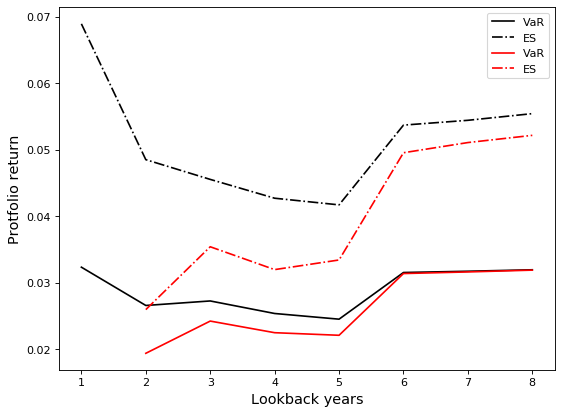

In [147]:
print('The values without corona (stress period) are lower')
plt.figure(figsize=(8,6),dpi=80)
plt.plot(VaR_trend,label='VaR',color='k')
plt.plot(ES_trend,label='ES',color='k',ls='-.')
plt.plot(VaR_trend_ex,label='VaR',color='r')
plt.plot(ES_trend_ex,label='ES',color='r',ls='-.')
plt.xticks(np.arange(8), (1,2,3,4,5,6,7,8))
plt.xlabel('Lookback years',fontsize=13)
plt.ylabel('Protfolio return',fontsize=13)
plt.legend()

**Pan:** Discussion points <br>
1. Ask about the dates
2. Ask about outliers
3. I set the monetary values as the percertage * the initial investment values (initials values of the portfolio?) <br>
Not sure if it's correct!!!!!!

### 2. Student t-distribution

### Check student t-assumption with QQ-plots

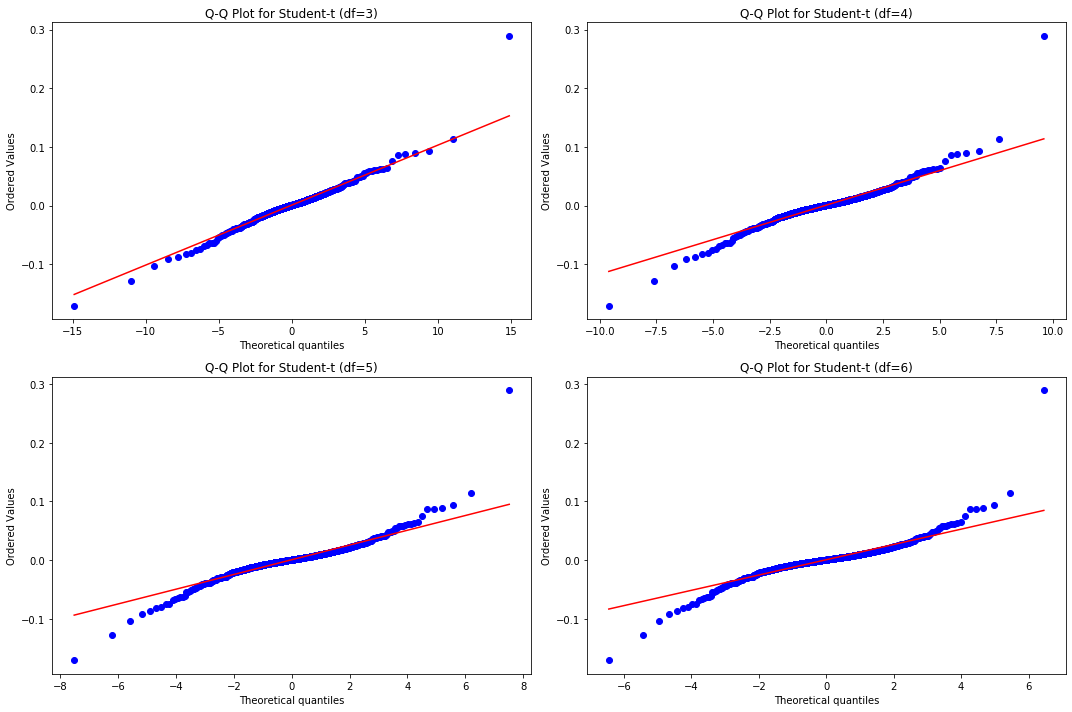

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
plt.subplot(2, 2, 1)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(3), plot=plt)
plt.title("Q-Q Plot for Student-t (df=3)")
plt.tight_layout()
plt.subplot(2, 2, 2)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(4), plot=plt)
plt.title("Q-Q Plot for Student-t (df=4)")
plt.tight_layout()
plt.subplot(2, 2, 3)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(5), plot=plt)
plt.title("Q-Q Plot for Student-t (df=5)")
plt.tight_layout()
plt.subplot(2, 2, 4)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(6), plot=plt)
plt.title("Q-Q Plot for Student-t (df=6)")
plt.tight_layout()
plt.show()

In [26]:
def fnVaR_t(dfData, weights, lookback, df, alpha, percent, initial_investment):
    """
    purpose:
        calculates VaR and ES with variance-covariance method
        using a t-distribution
    input:
        dfData, dataframe
        weights, weights vector
        apha, significance value
        lookback, lookback period
        df, degrees of freedom
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # express years in days
    years = lookback
    # select last n years of data
    DataTemp = dfData.iloc[-years * 250 :, :-1]  # converted to days

    # calculate mean
    mean = np.array(np.mean(DataTemp)) @ weights.T
    mean = mean[0]

    # calculate covariance
    cov = np.cov(DataTemp, rowvar=False)
    # calculate variance
    variance = weights @ cov @ weights.T
    variance = (
        variance[0][0] * (df - 2) / df
    )  # account for variance of standard student-t

    # calculate quantile
    t = sc.stats.t.ppf(alpha, df)
    VaR = -mean + t * np.sqrt(variance)
    VaR = -VaR

    # calculate ES
    mean_return = dfData["portfolio_return"][-years * 250 :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output
    if percent[0] == True:
        print(
            "DF=", df,
        )

        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR * 100, 2),
            "%",
            round(ES * 100, 2),
            "%",
        )
    else:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )
    return VaR, ES



In [27]:
fnVaR_t(df_prices, weights, lookback,   3, 0.025, [True,0.975],initial_investment)
fnVaR_t(df_prices, weights, lookback,   3, 0.025,[False, 0.975],initial_investment)
fnVaR_t(df_prices, weights, lookback,   3, 0.01, [True,0.99],initial_investment)
fnVaR_t(df_prices, weights, lookback,   3, 0.01, [False,0.99],initial_investment)

fnVaR_t(df_prices, weights, lookback,   4, 0.025, [True,0.975],initial_investment)
fnVaR_t(df_prices, weights, lookback,   4, 0.025, [False, 0.975],initial_investment)
fnVaR_t(df_prices, weights, lookback,   4, 0.01, [True,0.99],initial_investment)
fnVaR_t(df_prices, weights, lookback,   4, 0.01, [False,0.99],initial_investment)

fnVaR_t(df_prices, weights, lookback,   5, 0.025, [True,0.975],initial_investment)
fnVaR_t(df_prices, weights, lookback,   5, 0.025,[False, 0.975],initial_investment)
fnVaR_t(df_prices, weights, lookback,   5, 0.01, [True,0.99],initial_investment)
fnVaR_t(df_prices, weights, lookback,   5, 0.01, [False,0.99],initial_investment)

fnVaR_t(df_prices, weights, lookback,   6, 0.025, [True,0.975],initial_investment)
fnVaR_t(df_prices, weights, lookback,   6, 0.025, [False, 0.975],initial_investment)
fnVaR_t(df_prices, weights, lookback,   6, 0.01, [True,0.99],initial_investment)
fnVaR_t(df_prices, weights, lookback,   6, 0.01, [False,0.99],initial_investment)

DF= 3
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.07 %
( 97.5 %  VaR, ES) in monetary terms is:  23813.35 40655.75
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.38 % 5.87 %
( 99.0 %  VaR, ES) in monetary terms is:  33751.22 58728.84
DF= 4
( 97.5 %  VaR, ES) in percent is:  2.54 % 4.27 %
( 97.5 %  VaR, ES) in monetary terms is:  25408.31 42710.76
DF= 4
( 99.0 %  VaR, ES) in percent is:  3.41 % 6.12 %
( 99.0 %  VaR, ES) in monetary terms is:  34104.99 61204.94
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.58 % 4.35 %
( 97.5 %  VaR, ES) in monetary terms is:  25762.15 43450.69
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.36 % 5.87 %
( 99.0 %  VaR, ES) in monetary terms is:  33559.7 58728.84
DF= 6
( 97.5 %  VaR, ES) in percent is:  2.58 % 4.43 %
( 97.5 %  VaR, ES) in monetary terms is:  25847.45 44253.89
DF= 6
( 99.0 %  VaR, ES) in percent is:  3.3 % 5.66 %
( 99.0 %  VaR, ES) in monetary terms is:  33046.64 56623.0


(0.033046636612657505, 0.05662299904490808)

### 3. Historical simulation method

In [28]:
def fnVaR_hist(dfData, weights, alpha, lookback, percent, initial_investment):
    """
    purpose:
        calculates VaR and ES with historical simulation
    input:
        dfData, dataframe
        weights, weights vector
        apha, significance value
        lookback, lookback period
        df, degrees of freedom
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # because the percentile function takes alpha=e[0,100]
    alpha = alpha * 100

    # express years in days
    years = lookback
    # select last n years of data
    DataTemp = dfData.iloc[-years * 250 :, :-1]  # converted to days

    # calculate mean
    mean = np.array(np.mean(DataTemp)) @ weights.T
    mean = mean[0]

    # calculate covariance
    cov = np.cov(DataTemp, rowvar=False)
    # calculate variance
    variance = weights @ cov @ weights.T
    std = np.sqrt(variance[0][0])

    # calculate quantile
    VaR = sc.percentile(DataTemp, alpha)
    VaR = -VaR

    # calculate ES
    mean_return = dfData["portfolio_return"][-years * 250 :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output
    if percent[0] == True:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR * 100, 2),
            "%",
            round(ES * 100, 2),
            "%",
        )
    else:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )
    return VaR, ES


In [29]:
fnVaR_hist(df_prices, weights, 0.025, lookback, [True,0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.025, lookback, [False,0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, lookback, [True,0.99], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, lookback, [False,0.99], initial_investment)

( 97.5 %  VaR, ES) in percent is:  4.91 % 8.09 %
( 97.5 %  VaR, ES) in monetary terms is:  49109.73 80900.89
( 99.0 %  VaR, ES) in percent is:  8.06 % 10.97 %
( 99.0 %  VaR, ES) in monetary terms is:  80638.67 109702.99


(0.08063866860205282, 0.10970299024000069)

### 4. EWMA

In [47]:
def fnVaR_EWMA(dfData, weights, ewma_con, alpha, lookback, percent,initial_investment):
    """
    purpose:
        calculates VaR and ES with EWMA method
        using a normal distribution
    input:
        dfData, dataframe
        weights, weights vector
        ewma_con, smoothing constant
        alpha, significance value
        lookback, lookback period
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # because the percentile function takes alpha=e[0,100]
    alpha = alpha * 100

    # express years in days
    years = lookback

    # select last n years of data
    DataTemp = dfData.iloc[-years * 250 :, :-1]  # converted to days

    # calculate covariance
    cov = np.cov(DataTemp, rowvar=False)

    # estimate a GARCH(1,1) model and store the one step ahead
    # forecasts in a vector
    vVariances = np.zeros((len(DataTemp), 5))
    # initialize variance
    for i in range(4):
        vVariances[0, i] = np.var(DataTemp.iloc[:, i])
    # calculate EWMA
    for i in range(1, len(DataTemp)):
        for j in range(4):
            sigma2hat = (
                ewma_con * vVariances[i - 1, j]
                + (1 - ewma_con) * DataTemp.iloc[i - 1, j] ** 2
            )
            vVariances[i, j] = sigma2hat
    # fill diagonal elements of covariance matrix with GARCH estimates
    np.fill_diagonal(cov, vVariances[-1, :])

    # calculate variance
    variance = weights @ cov @ weights.T
    std = np.sqrt(variance[0][0])

    # calculate mean
    mean = np.array(np.mean(DataTemp)) @ weights.T
    mean = mean[0]

    # calculate quantile
    VaR = sc.percentile(DataTemp, alpha)
    VaR = -VaR

    # calculate ES
    mean_return = dfData["portfolio_return"][-years * 250 :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output
    if percent[0] == True:
        print(
            "(",
            percent[1]* 100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR * 100, 2),
            "%",
            round(ES * 100, 2),
            "%",
        )
    else:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )


In [50]:
fnVaR_EWMA(df_prices, weights, 0.9, 0.025, lookback, [True,0.975],initial_investment)
fnVaR_EWMA(df_prices, weights, 0.9, 0.025, lookback, [False,0.975],initial_investment)
fnVaR_EWMA(df_prices, weights, 0.9, 0.01, lookback, [True,0.99],initial_investment)
fnVaR_EWMA(df_prices, weights, 0.9, 0.01, lookback, [False,0.99],initial_investment)

( 97.5 %  VaR, ES) in percent is:  5.35 % 8.87 %
( 97.5 %  VaR, ES) in monetary terms is:  53511.22 88744.78
( 99.0 %  VaR, ES) in percent is:  8.26 % 10.97 %
( 99.0 %  VaR, ES) in monetary terms is:  82613.25 109702.99


### 5.Filtered historical simulation using EWMA

In [34]:
''' Filtered historical simulation using EWMA '''
returns = data[['DE_1YBOND_return',"BTC_return", "DBC_return", "GSPC_return", "N225_return"]]
tVar = np.zeros((600+1,5))

##calculate variance at day-100 using the previous days
for i in range(5):
    tVar[0,i] = sc.var(returns.iloc[:-700,i])

#calculate first 100 days volatility
for i in range(5):
    for j in range(100):
        tVar[1+j,i] = 0.94*tVar[1+j-1,i]+0.06*returns.iloc[-700+j-1,i]**2
        
Z_matrix = np.zeros((500,5))
R_matrix = np.zeros((500,5))
VaR_all = np.zeros(5)
ES_all = np.zeros(5)
VaR_all_975 = np.zeros(5)
ES_all_975 = np.zeros(5)
# calculate first 500 days Z values and use them to approximate the VaR and ES on the 501th day
for i in range(5):
    for j in range(500):
        tVar[101+j,i] = 0.94*tVar[101+j-1,i]+0.06*returns.iloc[-600+j-1,i]**2
        Z_matrix[j,i] = returns.iloc[-600+j,i]/sc.sqrt(tVar[101+j,i])
        new_sigma = sc.sqrt(0.94*tVar[101+j,i]+0.06*returns.iloc[-600+j,i]**2)
        R_matrix[:,i] = Z_matrix[:,i]*new_sigma
        #print(new_sigma)
    VaR_all[i] = -sc.percentile(R_matrix[:,i],1)
    VaR_all_975[i] = -sc.percentile(R_matrix[:,i],25)    
    ES_list = [x for x in R_matrix[:,i] if x < -VaR_all[i]]
    ES_list_975 = [x for x in R_matrix[:,i] if x < -VaR_all_975[i]]
    ES_all[i] = -np.mean(ES_list)
    ES_all_975[i] = -np.mean(ES_list_975)
    print(VaR_all)

[0.07740809 0.         0.         0.         0.        ]
[0.07740809 0.12927929 0.         0.         0.        ]
[0.07740809 0.12927929 0.02464648 0.         0.        ]
[0.07740809 0.12927929 0.02464648 0.03003508 0.        ]
[0.07740809 0.12927929 0.02464648 0.03003508 0.01758317]


In [35]:
VaR = (VaR_all@weights.T)[0]
ES = (ES_all@weights.T)[0]
VaR_975 = (VaR_all_975@weights.T)[0]
ES_975 = (ES_all_975@weights.T)[0]
print(VaR)
print( "(", 0.99 * 100, "%"," VaR, ES) in percent is: ", round( VaR * 100, 2), "%", round(ES  * 100, 2), "%", )

print( "(", 0.99 * 100, "%", " VaR, ES) in monetary terms is: ", round(VaR  * initial_investment, 2), round(ES  * initial_investment, 2),)
print( "(", 0.975 * 100, "%"," VaR, ES) in percent is: ", round( VaR_975 * 100, 2), "%", round(ES_975  * 100, 2), "%", )

print( "(", 0.975 * 100, "%", " VaR, ES) in monetary terms is: ", round(VaR_975  * initial_investment, 2), round(ES_975  * initial_investment, 2),)

0.05579042379277042
( 99.0 %  VaR, ES) in percent is:  5.58 % 7.71 %
( 99.0 %  VaR, ES) in monetary terms is:  55790.42 77068.4
( 97.5 %  VaR, ES) in percent is:  0.84 % 2.27 %
( 97.5 %  VaR, ES) in monetary terms is:  8425.74 22724.21


In [105]:
import math
def FHSVaR(data,alpha , Period_Interval,EWMA_Discount_Factor = 0.94):
     
        
    # Defining exponentially smoothed weights components 
    Degree_of_Freedom = np.zeros(Period_Interval)
    Weights = np.zeros(Period_Interval)
    Degree_of_Freedom[0]=1.0
    Degree_of_Freedom[1]=EWMA_Discount_Factor
    Range = range(Period_Interval)
    for i in range(2,Period_Interval):
        Degree_of_Freedom[i]=Degree_of_Freedom[1]**Range[i]
    for i in range(Period_Interval):
        Weights[i]=Degree_of_Freedom[i]/sum(Degree_of_Freedom)


    Value_at_Risk = pd.Series(index=data.index)
    EWMAstdev = np.zeros(len(data)-Period_Interval)
    stndrData = pd.Series(index=data.index)
    
    # For efficiency here we square returns first so the loop does not do it repeadetly 
    sqrdReturns = data**2

    # Computations here happen in different times, because we first need all the EWMAstdev
    # First get the stdev according to the EWMA
    for i in range(0,len(data)-Period_Interval):
        if i == 0: sqrdData = sqrdReturns[-(Period_Interval):]
        else: sqrdData = sqrdReturns[-(Period_Interval+i):-i]

        EWMAstdev[-i-1]=math.sqrt(sum(Weights*sqrdData))
    #print(EWMAstdev)
    # Now get the Standardized data by dividing for the EWMAstdev.
    # Length is here -1 because we standardize by the EWMAstdev of the PREVIOUS period.
    # Hence also EWMAstdev is [-i-2] instead of [-i-1].
    for i in range(0,len(data)-Period_Interval-1):
        stndrData[-i-1]=data.iloc[-i-1]/EWMAstdev[-i-2]
    #print(stndrData)
    stndrData = stndrData[pd.notnull(stndrData)]
    #Finally get the percentile and unfilter back the data
    for i in range(0,len(stndrData)-Period_Interval):
        if i == 0: stndrData2 = stndrData[-(Period_Interval):]
        else: stndrData2 = stndrData[-(Period_Interval+i):-i]   
        print(stndrData2)
        stndrData_pct=np.percentile(stndrData2,alpha)
    # Unfilter back with the CURRENT stdev
        Value_at_Risk[-i-1]=-(stndrData_pct*EWMAstdev[-i-1])

    print(Value_at_Risk)
    # For FHS the single take of VaR does not work because we need to standardize for the preceeding stdev
    # hence it is always necessary to calculate the whole series and take the last value
    VaR = Value_at_Risk[-1]
    ES = np.mean([x for x in Value_at_Risk if -x < -VaR])


    return(VaR,ES)

def fnEWMA(data,alpha , Period_Interval,weights,initial_investment,EWMA_Discount_Factor = 0.94):
    VaR = np.zeros(5)
    ES = np.zeros(5)
    for i in range(5):
        VaR[i] = FHSVaR(data.iloc[:,i],alpha , Period_Interval,EWMA_Discount_Factor)[0]
        ES[i] = FHSVaR(data.iloc[:,i],alpha , Period_Interval,EWMA_Discount_Factor)[1]
    total_VaR = VaR@weights.T
    total_ES = ES@weights.T
    return total_VaR[0],total_ES[0]

In [106]:
print('97.5% (VaR,ES):')
print(fnEWMA(returns.iloc[1:-200,:],0.025 , 1000,weights,initial_investment,0.94))
print('99% (VaR,ES):')
print(fnEWMA(returns.iloc[1:-200,:],0.01 , 1000,weights,initial_investment,0.94))

97.5% (VaR,ES):
[0.03218883 0.03301129 0.03400259 0.03504823 0.03597603 0.03363817
 0.03448753 0.03417928 0.03509991 0.03613132 0.0347779  0.0351662
 0.03580268 0.03460678 0.0328784  0.03185788 0.03263962 0.03248314
 0.03274847 0.03266695 0.03353293 0.03458565 0.03534793 0.03586197
 0.0354341  0.03612236 0.03687767 0.03793475 0.03861354 0.03845618
 0.03952831 0.03936527 0.04025404 0.04107373 0.04176952 0.04300783
 0.04427204 0.04535386 0.04142684 0.0420046  0.04313544 0.04375009
 0.04397861 0.04534921 0.04607015 0.04690935 0.04835955 0.04964755
 0.05120193 0.05270853 0.05364073 0.05403691 0.05573424 0.05719104
 0.05687028 0.05794778 0.05946021 0.06100241 0.06183655 0.0634137
 0.06539404 0.06639534 0.06127962 0.06302256 0.06455941 0.06649394
 0.06847848 0.06760054 0.06931145 0.06945638 0.06961023 0.0709708
 0.07201222 0.072013   0.07427531 0.07353767 0.0758378  0.07613616
 0.07846991 0.06922186 0.05778082 0.05920469 0.0608954  0.04849227
 0.04976007 0.04759653 0.04804065 0.04949795 0.05

1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
        ..
1907   NaN
1908   NaN
1909   NaN
1910   NaN
1911   NaN
Length: 1911, dtype: float64


KeyError: -1

### 6. GARCH(1,1) with constant correlation matrix

In [44]:
from scipy.optimize import minimize

def fGarchFilter(vData, dOmega, dAlpha, dBeta, dSigma2):
    
    # initialize sizes and formats
    iT = vData.shape[0]
    vVariances = np.zeros(iT)
    vLikelihoodValues = np.ones(iT)
    
    # filter variances and compute likelihood contributions by
    # a loop over the observations
    for i1 in range(iT):
        
        # update filtered variances
        vVariances[i1] = dSigma2
        
        # compute the likelihood contribution
        vLikelihoodValues[i1] = -0.5*np.log(dSigma2) - 0.5*vData.iloc[i1]*vData.iloc[i1]/dSigma2
        
        # update the filter
        dSigma2 = dOmega + dBeta * dSigma2 + dAlpha * vData.iloc[i1] * vData.iloc[i1]
        
    # add likelihood constants
    vLikelihoodValues = vLikelihoodValues - 0.5 * np.log(2*np.pi)
    
    # return filtered variances and likelihood values
    return (vVariances, vLikelihoodValues)


class cMaximizeLikelihood:
    def __init__(self):
        self.x0 = []
        self.x = []
        self.tx0 = []
        self.tx = []
        self.likelihoodvalue = []
        self.tcovariancematrix = []
        self.covariancematrix = []
        self.filter = []
        self.success = False


def fMaximizeLikelihood(vData):

    cReturnValue = cMaximizeLikelihood()

    def LOCAL_fParameterTransform(vTheta, bShapeAsVector=False):
        r = (
            (np.exp(vTheta[0])),
            (np.exp(vTheta[1])),
            (1/(1+np.exp(-vTheta[2])))
        )
        if (bShapeAsVector == True):
            return np.append([], r)
        else:
            return r
    
    def LOCAL_fObjective(vTheta, bForAllT=False):
        # initialize the parameter values
        dOmega, dAlpha, dBeta = LOCAL_fParameterTransform(vTheta)
        dSigma2 = np.var(vData)

        # run the filter
        vVariances, vLikelihoodValues = fGarchFilter(vData, dOmega, dAlpha, dBeta, dSigma2)
        cReturnValue.filter = vVariances
        if (bForAllT == True):
            dObjValue = vLikelihoodValues
        else:
            dObjValue = -np.mean(vLikelihoodValues)
        
        return dObjValue

    
    # initialize starting values and return value
    vTheta = np.log([1, 0.05, 0.93])
    vTheta[0] = np.log(np.var(vData) * (1 - 0.98))
    cReturnValue.x0 = vTheta
    cReturnValue.tx0 = LOCAL_fParameterTransform(vTheta)
    
    # do the optimization
    tSol = minimize(LOCAL_fObjective, vTheta, method='Nelder-Mead', options={'disp': True, 'maxiter':250})
    cReturnValue.success = tSol['success']
    # check for success and store results
    if (tSol['success'] != True):
        print("*** no true convergence: ",tSol['message'])
    else:
        cReturnValue.x = tSol['x']
        cReturnValue.tx = LOCAL_fParameterTransform(cReturnValue.x)
        cReturnValue.likelihoodvalue = -vData.shape[0] * tSol['fun']

    return cReturnValue

In [52]:
def fnVaR_GARCH(dfData, weights, alpha, lookback, percent,initial_investment):
    """
    purpose:
        calculates VaR and ES with GARCH method
        using a normal distribution
    input:
        dfData, dataframe
        weights, weights vector
        apha, significance value
        lookback, lookback period
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha= 1-alpha
    
    # express years in days
    years= lookback
    # select last n years of data
    DataTemp= dfData.iloc[-years*250:,:-1]
    # calculate covariance
    cov= np.cov(DataTemp, rowvar= False)    
    # estimate a GARCH(1,1) model and store the one step ahead
    # forecasts in a vector
    vVariances= np.zeros(5)
    for i in range(5):
        out = fMaximizeLikelihood(DataTemp.iloc[:,i])
        dOmega, dAlpha, dBeta= out.tx
        sigma2hat= dOmega + dAlpha*DataTemp.iloc[-1,i]**2+dBeta*out.filter[-1]
        vVariances[i]= sigma2hat
    # fill diagonal elements of covariance matrix with GARCH estimates
    np.fill_diagonal(cov, vVariances)
    # calculate the variance
    variance= weights@cov@weights.T
    variance= variance[0][0]
    # calculate mean
    mean= np.array(np.mean(DataTemp))@weights.T
    mean= mean[0]
    # calculate quantile
    z= sc.stats.norm.ppf(alpha)
    VaR= mean + z * np.sqrt(variance)
    VaR= -VaR
    # calculate ES
    mean_return = dfData["portfolio_return"][-years * 250 :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES= -np.mean(ES_list)
    if percent[0] == True:
        print(
            "(",
            percent[1]* 100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR * 100, 2),
            "%",
            round(ES * 100, 2),
            "%",
        )
    else:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),)
    return VaR, ES

In [53]:
fnVaR_GARCH(df_prices, weights, 0.025, 4, [True,0.975],initial_investment)
fnVaR_GARCH(df_prices, weights, 0.025, 4, [False,0.975],initial_investment)
fnVaR_GARCH(df_prices, weights, 0.01, 4, [True,0.99],initial_investment)
fnVaR_GARCH(df_prices, weights, 0.01, 4, [False,0.99],initial_investment)

Optimization terminated successfully.
         Current function value: -2.660354
         Iterations: 154
         Function evaluations: 278
Optimization terminated successfully.
         Current function value: -1.641958
         Iterations: 142
         Function evaluations: 248
Optimization terminated successfully.
         Current function value: -3.220193
         Iterations: 183
         Function evaluations: 323
Optimization terminated successfully.
         Current function value: -3.442846
         Iterations: 127
         Function evaluations: 227
Optimization terminated successfully.
         Current function value: -3.166763
         Iterations: 162
         Function evaluations: 286
( 97.5 %  VaR, ES) in percent is:  4.38 % 7.51 %
Optimization terminated successfully.
         Current function value: -2.660354
         Iterations: 154
         Function evaluations: 278
Optimization terminated successfully.
         Current function value: -1.641958
         Iterations: 142

(0.05205203624756683, 0.08874478020221385)

### Backtesting all five methods

In [34]:
def fnRollingVaR(dfData, weights, alpha, lookback, sm_const, df,percent=[True,0.975]):
    '''
    purpose:
        calculate VaR with a rolling window
    input:
        dfData, dataframe of risk factors
        weights, portfolio weights
        alpha, significance level
        lookback, lookback period
        sm_const, smoothing constant for EWMA
        df, degrees of freedom for t-distribution
    output
        dfVaR, dataframe of VaR for every day
    '''
    windowsize= lookback*250
    N= len(dfData)-windowsize
    dfVaR= pd.DataFrame(np.zeros((N,8)))
    dfVaR.index = dfData.index[windowsize:]
    dfVaR.columns= ["VaR_n", "ES_n", "VaR_t", "ES_t", "VaR_hist", "ES_hist","VaR_GARCH","ES_GARCH"]
    # VaR and ES for 1 year lookback
    for i in range(N):
        # calculate rolling window
        DataTemp= dfData.iloc[0+i:windowsize+i,:]
        # calculate VaR
        dfVaR.iloc[i,0], dfVaR.iloc[i,1]= fnVaR_n(DataTemp, weights, alpha, lookback,percent,initial_investment )
        dfVaR.iloc[i,2], dfVaR.iloc[i,3]= fnVaR_t(DataTemp, weights,lookback,df, alpha, percent,initial_investment)
        dfVaR.iloc[i,4], dfVaR.iloc[i,5]= fnVaR_hist(DataTemp, weights, alpha, lookback, percent,initial_investment)
        #dfVaR.iloc[i,6], dfVaR.iloc[i,7]= fnVaR_EWMA(DataTemp, weights, sm_const, alpha, lookback, True)
        dfVaR.iloc[i,6], dfVaR.iloc[i,7]= fnVaR_GARCH(df_prices, weights, alpha, lookback, percent,initial_investment)
    
    return dfVaR


In [67]:
df = fnRollingVaR(df_prices, weights, 0.025, 1, 0.94, 5,percent=[True,0.975])

/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


( 97.5 %  VaR, ES) in percent is:  nan % nan %
DF= 5
( 97.5 %  VaR, ES) in percent is:  nan % nan %
( 97.5 %  VaR, ES) in percent is:  nan % nan %
( 97.5 %  VaR, ES) in percent is:  5.12 % 7.79 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.2 % 7.79 %
( 97.5 %  VaR, ES) in percent is:  9.89 % 10.32 %
( 97.5 %  VaR, ES) in percent is:  5.11 % 7.79 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.19 % 7.79 %
( 97.5 %  VaR, ES) in percent is:  9.89 % 10.32 %
( 97.5 %  VaR, ES) in percent is:  5.11 % 7.79 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.19 % 7.79 %
( 97.5 %  VaR, ES) in percent is:  9.75 % 10.32 %
( 97.5 %  VaR, ES) in percent is:  5.1 % 7.79 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.18 % 7.79 %
( 97.5 %  VaR, ES) in percent is:  9.75 % 10.32 %
( 97.5 %  VaR, ES) in percent is:  5.1 % 7.79 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.18 % 7.79 %
( 97.5 %  VaR, ES) in percent is:  9.75 % 10.32 %
( 97.5 %  VaR, ES) in percent is:  5.1 % 7.79 %
DF= 5
( 97.5 %  VaR, ES) in percent is

( 97.5 %  VaR, ES) in percent is:  3.95 % 7.37 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.02 % 7.37 %
( 97.5 %  VaR, ES) in percent is:  8.8 % 10.32 %
( 97.5 %  VaR, ES) in percent is:  3.96 % 7.37 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.02 % 7.37 %
( 97.5 %  VaR, ES) in percent is:  8.8 % 10.32 %
( 97.5 %  VaR, ES) in percent is:  3.96 % 7.37 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.02 % 7.37 %
( 97.5 %  VaR, ES) in percent is:  8.51 % 9.51 %
( 97.5 %  VaR, ES) in percent is:  3.99 % 7.37 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.05 % 7.37 %
( 97.5 %  VaR, ES) in percent is:  8.51 % 9.51 %
( 97.5 %  VaR, ES) in percent is:  3.99 % 7.37 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.05 % 7.37 %
( 97.5 %  VaR, ES) in percent is:  8.8 % 10.32 %
( 97.5 %  VaR, ES) in percent is:  4.01 % 7.37 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.07 % 7.37 %
( 97.5 %  VaR, ES) in percent is:  8.8 % 10.32 %
( 97.5 %  VaR, ES) in percent is:  4.01 % 7.37 %
DF= 5
( 97.5 %  VaR, ES) in perce

DF= 5
( 97.5 %  VaR, ES) in percent is:  3.01 % 4.48 %
( 97.5 %  VaR, ES) in percent is:  6.42 % 8.7 %
( 97.5 %  VaR, ES) in percent is:  2.95 % 4.48 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.0 % 4.48 %
( 97.5 %  VaR, ES) in percent is:  6.42 % 8.7 %
( 97.5 %  VaR, ES) in percent is:  2.96 % 4.48 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.0 % 4.48 %
( 97.5 %  VaR, ES) in percent is:  6.42 % 8.7 %
( 97.5 %  VaR, ES) in percent is:  2.93 % 4.24 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.98 % 4.5 %
( 97.5 %  VaR, ES) in percent is:  6.4 % 8.7 %
( 97.5 %  VaR, ES) in percent is:  2.93 % 4.24 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.5 %
( 97.5 %  VaR, ES) in percent is:  6.4 % 8.7 %
( 97.5 %  VaR, ES) in percent is:  2.93 % 4.24 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.5 %
( 97.5 %  VaR, ES) in percent is:  6.29 % 8.7 %
( 97.5 %  VaR, ES) in percent is:  2.93 % 4.24 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.5 %
( 97.5 %  VaR, ES) in percent is:  6.29 %

DF= 5
( 97.5 %  VaR, ES) in percent is:  2.34 % 3.18 %
( 97.5 %  VaR, ES) in percent is:  3.8 % nan %
( 97.5 %  VaR, ES) in percent is:  2.3 % 2.89 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.34 % 3.18 %
( 97.5 %  VaR, ES) in percent is:  3.8 % nan %
( 97.5 %  VaR, ES) in percent is:  2.31 % 2.89 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.34 % 3.18 %
( 97.5 %  VaR, ES) in percent is:  3.8 % nan %
( 97.5 %  VaR, ES) in percent is:  2.32 % 3.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.35 % 3.18 %
( 97.5 %  VaR, ES) in percent is:  3.8 % nan %
( 97.5 %  VaR, ES) in percent is:  2.35 % 3.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.38 % 3.18 %
( 97.5 %  VaR, ES) in percent is:  3.74 % nan %
( 97.5 %  VaR, ES) in percent is:  2.35 % 3.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.38 % 3.18 %
( 97.5 %  VaR, ES) in percent is:  3.74 % nan %
( 97.5 %  VaR, ES) in percent is:  2.48 % 3.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.52 % 3.18 %
( 97.5 %  VaR, ES) in percent is:  3.7

( 97.5 %  VaR, ES) in percent is:  3.33 % 5.45 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.38 % 5.45 %
( 97.5 %  VaR, ES) in percent is:  5.57 % 7.26 %
( 97.5 %  VaR, ES) in percent is:  3.33 % 5.45 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.38 % 5.45 %
( 97.5 %  VaR, ES) in percent is:  5.57 % 7.26 %
( 97.5 %  VaR, ES) in percent is:  3.33 % 5.45 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.38 % 5.45 %
( 97.5 %  VaR, ES) in percent is:  5.57 % 7.26 %
( 97.5 %  VaR, ES) in percent is:  3.34 % 5.45 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.38 % 5.45 %
( 97.5 %  VaR, ES) in percent is:  5.57 % 7.26 %
( 97.5 %  VaR, ES) in percent is:  3.34 % 5.45 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.39 % 5.45 %
( 97.5 %  VaR, ES) in percent is:  5.78 % 7.26 %
( 97.5 %  VaR, ES) in percent is:  3.34 % 5.45 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.39 % 5.45 %
( 97.5 %  VaR, ES) in percent is:  5.78 % 7.26 %
( 97.5 %  VaR, ES) in percent is:  3.32 % 5.45 %
DF= 5
( 97.5 %  VaR, ES) in perce

( 97.5 %  VaR, ES) in percent is:  4.5 % 6.58 %
( 97.5 %  VaR, ES) in percent is:  3.35 % 5.95 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.4 % 5.95 %
( 97.5 %  VaR, ES) in percent is:  4.5 % 6.58 %
( 97.5 %  VaR, ES) in percent is:  3.37 % 5.95 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.42 % 5.95 %
( 97.5 %  VaR, ES) in percent is:  4.48 % 6.58 %
( 97.5 %  VaR, ES) in percent is:  3.37 % 5.95 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.42 % 5.95 %
( 97.5 %  VaR, ES) in percent is:  4.48 % 6.58 %
( 97.5 %  VaR, ES) in percent is:  3.37 % 5.95 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.42 % 5.95 %
( 97.5 %  VaR, ES) in percent is:  4.48 % 6.58 %
( 97.5 %  VaR, ES) in percent is:  3.71 % 5.95 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.76 % 5.95 %
( 97.5 %  VaR, ES) in percent is:  4.42 % 6.58 %
( 97.5 %  VaR, ES) in percent is:  3.73 % 5.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.79 % 5.54 %
( 97.5 %  VaR, ES) in percent is:  4.48 % 6.58 %
( 97.5 %  VaR, ES) in percent is:  3

( 97.5 %  VaR, ES) in percent is:  8.32 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  6.16 % 9.49 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  6.25 % 9.49 %
( 97.5 %  VaR, ES) in percent is:  8.32 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  6.16 % 9.49 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  6.25 % 9.49 %
( 97.5 %  VaR, ES) in percent is:  8.32 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  6.16 % 9.49 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  6.25 % 9.49 %
( 97.5 %  VaR, ES) in percent is:  8.32 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  6.16 % 9.49 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  6.25 % 9.49 %
( 97.5 %  VaR, ES) in percent is:  8.32 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  6.15 % 9.49 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  6.24 % 9.49 %
( 97.5 %  VaR, ES) in percent is:  8.32 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  6.15 % 9.49 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  6.25 % 9.49 %
( 97.5 %  VaR, ES) in percent is:  8.42 % 17.09 %
( 97.5 %  VaR, ES) in perc

( 97.5 %  VaR, ES) in percent is:  7.17 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  5.63 % 11.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.72 % 11.71 %
( 97.5 %  VaR, ES) in percent is:  7.17 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  5.63 % 11.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.72 % 11.71 %
( 97.5 %  VaR, ES) in percent is:  7.17 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  5.64 % 11.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.72 % 11.71 %
( 97.5 %  VaR, ES) in percent is:  7.1 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  5.64 % 11.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.72 % 11.71 %
( 97.5 %  VaR, ES) in percent is:  7.1 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  5.64 % 11.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.72 % 11.71 %
( 97.5 %  VaR, ES) in percent is:  7.1 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  5.64 % 11.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.72 % 11.71 %
( 97.5 %  VaR, ES) in percent is:  7.1 % 17.09 %
( 97.5 %  VaR, ES)

( 97.5 %  VaR, ES) in percent is:  5.48 % 11.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.56 % 11.71 %
( 97.5 %  VaR, ES) in percent is:  6.77 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  5.48 % 11.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.56 % 11.71 %
( 97.5 %  VaR, ES) in percent is:  6.77 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  5.5 % 11.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.58 % 11.71 %
( 97.5 %  VaR, ES) in percent is:  6.77 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  5.48 % 11.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.57 % 11.71 %
( 97.5 %  VaR, ES) in percent is:  6.77 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  5.46 % 11.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.54 % 11.71 %
( 97.5 %  VaR, ES) in percent is:  6.77 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  5.45 % 11.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  5.54 % 11.71 %
( 97.5 %  VaR, ES) in percent is:  6.77 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  5.44 % 11.71 %
DF= 5
( 97.5 % 

( 97.5 %  VaR, ES) in percent is:  4.84 % 9.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.92 % 9.33 %
( 97.5 %  VaR, ES) in percent is:  4.98 % 9.33 %
( 97.5 %  VaR, ES) in percent is:  4.85 % 9.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.92 % 9.33 %
( 97.5 %  VaR, ES) in percent is:  4.92 % 9.33 %
( 97.5 %  VaR, ES) in percent is:  4.43 % 5.2 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.5 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  4.71 % 5.46 %
( 97.5 %  VaR, ES) in percent is:  4.42 % 5.2 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.49 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  4.92 % 5.46 %
( 97.5 %  VaR, ES) in percent is:  4.23 % 5.2 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.3 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  4.92 % 5.46 %
( 97.5 %  VaR, ES) in percent is:  4.21 % 5.46 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.28 % 5.46 %
( 97.5 %  VaR, ES) in percent is:  4.71 % 5.46 %
( 97.5 %  VaR, ES) in percent is:  2.06 % 3.97 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  

( 97.5 %  VaR, ES) in percent is:  4.09 % 5.46 %
( 97.5 %  VaR, ES) in percent is:  1.86 % 3.95 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.89 % 3.95 %
( 97.5 %  VaR, ES) in percent is:  4.09 % 5.46 %
( 97.5 %  VaR, ES) in percent is:  1.86 % 3.95 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.89 % 3.95 %
( 97.5 %  VaR, ES) in percent is:  4.09 % 5.46 %
( 97.5 %  VaR, ES) in percent is:  1.86 % 3.95 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.89 % 3.95 %
( 97.5 %  VaR, ES) in percent is:  4.09 % 5.46 %
( 97.5 %  VaR, ES) in percent is:  1.86 % 3.95 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.89 % 3.95 %
( 97.5 %  VaR, ES) in percent is:  4.09 % 5.46 %
( 97.5 %  VaR, ES) in percent is:  1.86 % 3.95 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.89 % 3.95 %
( 97.5 %  VaR, ES) in percent is:  4.09 % 5.46 %
( 97.5 %  VaR, ES) in percent is:  1.86 % 3.95 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.89 % 3.95 %
( 97.5 %  VaR, ES) in percent is:  4.09 % 5.46 %
( 97.5 %  VaR, ES) in percent is:

( 97.5 %  VaR, ES) in percent is:  3.75 % 4.74 %
( 97.5 %  VaR, ES) in percent is:  2.08 % 3.99 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.11 % 3.99 %
( 97.5 %  VaR, ES) in percent is:  3.75 % 4.74 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 3.99 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.11 % 3.99 %
( 97.5 %  VaR, ES) in percent is:  3.75 % 4.74 %
( 97.5 %  VaR, ES) in percent is:  2.09 % 3.85 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.12 % 3.85 %
( 97.5 %  VaR, ES) in percent is:  3.79 % 5.07 %
( 97.5 %  VaR, ES) in percent is:  2.1 % 3.85 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.13 % 3.85 %
( 97.5 %  VaR, ES) in percent is:  3.88 % 5.07 %
( 97.5 %  VaR, ES) in percent is:  2.1 % 3.85 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.13 % 3.85 %
( 97.5 %  VaR, ES) in percent is:  3.88 % 5.07 %
( 97.5 %  VaR, ES) in percent is:  2.09 % 3.85 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.13 % 3.85 %
( 97.5 %  VaR, ES) in percent is:  3.88 % 5.07 %
( 97.5 %  VaR, ES) in percent is:  

( 97.5 %  VaR, ES) in percent is:  3.44 % 4.17 %
( 97.5 %  VaR, ES) in percent is:  1.84 % 2.82 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.87 % 2.82 %
( 97.5 %  VaR, ES) in percent is:  3.44 % 4.17 %
( 97.5 %  VaR, ES) in percent is:  1.85 % 2.82 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.88 % 2.82 %
( 97.5 %  VaR, ES) in percent is:  3.44 % 4.17 %
( 97.5 %  VaR, ES) in percent is:  1.85 % 2.82 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.88 % 2.82 %
( 97.5 %  VaR, ES) in percent is:  3.44 % 4.17 %
( 97.5 %  VaR, ES) in percent is:  1.85 % 2.82 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.88 % 2.82 %
( 97.5 %  VaR, ES) in percent is:  3.44 % 4.17 %
( 97.5 %  VaR, ES) in percent is:  1.85 % 2.82 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.88 % 2.82 %
( 97.5 %  VaR, ES) in percent is:  3.44 % 4.17 %
( 97.5 %  VaR, ES) in percent is:  1.85 % 2.82 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.88 % 2.82 %
( 97.5 %  VaR, ES) in percent is:  3.44 % 4.17 %
( 97.5 %  VaR, ES) in percent is:

( 97.5 %  VaR, ES) in percent is:  2.0 % 3.4 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.03 % 3.4 %
( 97.5 %  VaR, ES) in percent is:  3.64 % 4.44 %
( 97.5 %  VaR, ES) in percent is:  2.0 % 3.4 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.03 % 3.4 %
( 97.5 %  VaR, ES) in percent is:  3.69 % 4.44 %
( 97.5 %  VaR, ES) in percent is:  2.01 % 3.4 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.04 % 3.4 %
( 97.5 %  VaR, ES) in percent is:  3.69 % 4.44 %
( 97.5 %  VaR, ES) in percent is:  2.01 % 3.4 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.04 % 3.4 %
( 97.5 %  VaR, ES) in percent is:  3.69 % 4.44 %
( 97.5 %  VaR, ES) in percent is:  2.02 % 3.4 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.06 % 3.4 %
( 97.5 %  VaR, ES) in percent is:  3.69 % 4.44 %
( 97.5 %  VaR, ES) in percent is:  2.02 % 3.4 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.05 % 3.4 %
( 97.5 %  VaR, ES) in percent is:  3.69 % 4.44 %
( 97.5 %  VaR, ES) in percent is:  2.02 % 3.4 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.06 % 

( 97.5 %  VaR, ES) in percent is:  3.44 % 4.59 %
( 97.5 %  VaR, ES) in percent is:  1.84 % 2.74 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.87 % 2.74 %
( 97.5 %  VaR, ES) in percent is:  3.44 % 4.59 %
( 97.5 %  VaR, ES) in percent is:  1.84 % 2.74 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.87 % 2.74 %
( 97.5 %  VaR, ES) in percent is:  3.44 % 4.59 %
( 97.5 %  VaR, ES) in percent is:  1.85 % 2.74 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.88 % 2.74 %
( 97.5 %  VaR, ES) in percent is:  3.49 % 4.59 %
( 97.5 %  VaR, ES) in percent is:  1.85 % 2.74 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.87 % 2.74 %
( 97.5 %  VaR, ES) in percent is:  3.49 % 4.59 %
( 97.5 %  VaR, ES) in percent is:  1.84 % 2.74 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.87 % 2.74 %
( 97.5 %  VaR, ES) in percent is:  3.49 % 4.59 %
( 97.5 %  VaR, ES) in percent is:  1.84 % 2.74 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.87 % 2.74 %
( 97.5 %  VaR, ES) in percent is:  3.52 % 4.59 %
( 97.5 %  VaR, ES) in percent is:

DF= 5
( 97.5 %  VaR, ES) in percent is:  1.81 % 2.49 %
( 97.5 %  VaR, ES) in percent is:  3.1 % 3.4 %
( 97.5 %  VaR, ES) in percent is:  1.77 % 2.61 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.8 % 2.61 %
( 97.5 %  VaR, ES) in percent is:  3.0 % 3.4 %
( 97.5 %  VaR, ES) in percent is:  1.77 % 2.61 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.8 % 2.61 %
( 97.5 %  VaR, ES) in percent is:  3.0 % 3.4 %
( 97.5 %  VaR, ES) in percent is:  1.77 % 2.61 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.8 % 2.61 %
( 97.5 %  VaR, ES) in percent is:  3.0 % 3.4 %
( 97.5 %  VaR, ES) in percent is:  1.76 % 2.51 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.78 % 2.51 %
( 97.5 %  VaR, ES) in percent is:  3.18 % 3.4 %
( 97.5 %  VaR, ES) in percent is:  1.76 % 2.44 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.79 % 2.44 %
( 97.5 %  VaR, ES) in percent is:  3.2 % 3.4 %
( 97.5 %  VaR, ES) in percent is:  1.76 % 2.44 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.79 % 2.44 %
( 97.5 %  VaR, ES) in percent is:  3.2 % 

( 97.5 %  VaR, ES) in percent is:  3.69 % nan %
( 97.5 %  VaR, ES) in percent is:  2.04 % 2.68 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.07 % 2.68 %
( 97.5 %  VaR, ES) in percent is:  3.89 % nan %
( 97.5 %  VaR, ES) in percent is:  2.05 % 2.68 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.08 % 2.68 %
( 97.5 %  VaR, ES) in percent is:  3.89 % nan %
( 97.5 %  VaR, ES) in percent is:  2.05 % 2.68 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.08 % 2.68 %
( 97.5 %  VaR, ES) in percent is:  3.89 % nan %
( 97.5 %  VaR, ES) in percent is:  2.0 % 2.49 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.02 % 2.57 %
( 97.5 %  VaR, ES) in percent is:  3.89 % nan %
( 97.5 %  VaR, ES) in percent is:  1.99 % 2.49 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.02 % 2.57 %
( 97.5 %  VaR, ES) in percent is:  3.89 % nan %
( 97.5 %  VaR, ES) in percent is:  2.0 % 2.49 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.03 % 2.57 %
( 97.5 %  VaR, ES) in percent is:  3.89 % nan %
( 97.5 %  VaR, ES) in percent is:  1.99 % 

( 97.5 %  VaR, ES) in percent is:  2.42 % 3.44 %
( 97.5 %  VaR, ES) in percent is:  4.54 % nan %
( 97.5 %  VaR, ES) in percent is:  2.39 % 3.1 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.44 %
( 97.5 %  VaR, ES) in percent is:  4.54 % nan %
( 97.5 %  VaR, ES) in percent is:  2.39 % 3.1 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.44 %
( 97.5 %  VaR, ES) in percent is:  4.54 % nan %
( 97.5 %  VaR, ES) in percent is:  2.39 % 3.1 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.42 % 3.44 %
( 97.5 %  VaR, ES) in percent is:  4.65 % nan %
( 97.5 %  VaR, ES) in percent is:  2.39 % 3.1 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.44 %
( 97.5 %  VaR, ES) in percent is:  4.65 % nan %
( 97.5 %  VaR, ES) in percent is:  2.39 % 3.1 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.44 %
( 97.5 %  VaR, ES) in percent is:  4.65 % nan %
( 97.5 %  VaR, ES) in percent is:  2.39 % 3.1 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.44 %
( 97.5 %  VaR, ES) in percent is:  4.65 % nan

DF= 5
( 97.5 %  VaR, ES) in percent is:  2.95 % 4.13 %
( 97.5 %  VaR, ES) in percent is:  5.93 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.92 % 4.13 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.96 % 4.13 %
( 97.5 %  VaR, ES) in percent is:  5.93 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.92 % 4.13 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.13 %
( 97.5 %  VaR, ES) in percent is:  5.97 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.93 % 4.13 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.13 %
( 97.5 %  VaR, ES) in percent is:  5.99 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.93 % 4.13 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.98 % 4.42 %
( 97.5 %  VaR, ES) in percent is:  5.99 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.94 % 4.13 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.98 % 4.42 %
( 97.5 %  VaR, ES) in percent is:  5.99 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.94 % 4.13 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.98 % 4.42 %
( 97.5 %  VaR, ES) in perce

( 97.5 %  VaR, ES) in percent is:  6.36 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.8 % 3.91 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.84 % 4.13 %
( 97.5 %  VaR, ES) in percent is:  6.36 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.8 % 3.91 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.84 % 4.13 %
( 97.5 %  VaR, ES) in percent is:  6.36 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.8 % 3.91 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.84 % 4.13 %
( 97.5 %  VaR, ES) in percent is:  6.36 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 3.91 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.83 % 4.13 %
( 97.5 %  VaR, ES) in percent is:  6.36 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 3.91 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.83 % 4.13 %
( 97.5 %  VaR, ES) in percent is:  6.36 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 3.91 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.81 % 4.13 %
( 97.5 %  VaR, ES) in percent is:  6.36 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2

( 97.5 %  VaR, ES) in percent is:  2.46 % 4.15 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.5 % 4.15 %
( 97.5 %  VaR, ES) in percent is:  6.16 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.46 % 4.15 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.5 % 4.15 %
( 97.5 %  VaR, ES) in percent is:  6.01 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.46 % 4.15 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.5 % 4.15 %
( 97.5 %  VaR, ES) in percent is:  6.01 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 4.15 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.48 % 4.15 %
( 97.5 %  VaR, ES) in percent is:  6.01 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.46 % 3.83 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.5 % 3.83 %
( 97.5 %  VaR, ES) in percent is:  6.01 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.83 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.49 % 3.83 %
( 97.5 %  VaR, ES) in percent is:  6.01 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.83 %
DF= 5
( 97.5 %  VaR, ES) in percent i

( 97.5 %  VaR, ES) in percent is:  5.92 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.1 % 3.09 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.13 % 3.09 %
( 97.5 %  VaR, ES) in percent is:  5.92 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.1 % 3.09 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.13 % 3.09 %
( 97.5 %  VaR, ES) in percent is:  5.72 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.09 % 3.09 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.13 % 3.09 %
( 97.5 %  VaR, ES) in percent is:  5.72 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.08 % 3.09 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.12 % 3.09 %
( 97.5 %  VaR, ES) in percent is:  5.72 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.09 % 3.09 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.12 % 3.09 %
( 97.5 %  VaR, ES) in percent is:  5.72 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2.1 % 3.09 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.14 % 3.09 %
( 97.5 %  VaR, ES) in percent is:  5.72 % 6.69 %
( 97.5 %  VaR, ES) in percent is:  2

( 97.5 %  VaR, ES) in percent is:  1.85 % 2.71 %
( 97.5 %  VaR, ES) in percent is:  4.0 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  1.83 % 2.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.86 % 2.71 %
( 97.5 %  VaR, ES) in percent is:  4.0 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  1.84 % 2.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.87 % 2.71 %
( 97.5 %  VaR, ES) in percent is:  4.0 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  1.84 % 2.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.87 % 2.71 %
( 97.5 %  VaR, ES) in percent is:  4.0 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  1.84 % 2.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.87 % 2.71 %
( 97.5 %  VaR, ES) in percent is:  3.98 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  1.85 % 2.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.87 % 2.71 %
( 97.5 %  VaR, ES) in percent is:  3.92 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  1.85 % 2.71 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.88 % 2.71 %
( 97.5 %  VaR, ES) in percent is:  3.

( 97.5 %  VaR, ES) in percent is:  2.15 % 3.14 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.19 % 3.14 %
( 97.5 %  VaR, ES) in percent is:  4.0 % 4.49 %
( 97.5 %  VaR, ES) in percent is:  2.17 % 3.14 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.2 % 3.14 %
( 97.5 %  VaR, ES) in percent is:  4.0 % 4.49 %
( 97.5 %  VaR, ES) in percent is:  2.17 % 3.14 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.21 % 3.14 %
( 97.5 %  VaR, ES) in percent is:  4.0 % 4.49 %
( 97.5 %  VaR, ES) in percent is:  2.17 % 3.14 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.21 % 3.14 %
( 97.5 %  VaR, ES) in percent is:  4.0 % 4.49 %
( 97.5 %  VaR, ES) in percent is:  2.17 % 3.14 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.21 % 3.14 %
( 97.5 %  VaR, ES) in percent is:  4.0 % 4.49 %
( 97.5 %  VaR, ES) in percent is:  2.17 % 3.14 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.2 % 3.14 %
( 97.5 %  VaR, ES) in percent is:  4.0 % 4.49 %
( 97.5 %  VaR, ES) in percent is:  2.17 % 3.14 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  

( 97.5 %  VaR, ES) in percent is:  2.09 % 3.16 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.12 % 3.37 %
( 97.5 %  VaR, ES) in percent is:  3.59 % 4.95 %
( 97.5 %  VaR, ES) in percent is:  2.1 % 3.16 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.13 % 3.37 %
( 97.5 %  VaR, ES) in percent is:  3.59 % 4.95 %
( 97.5 %  VaR, ES) in percent is:  2.1 % 3.16 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.13 % 3.37 %
( 97.5 %  VaR, ES) in percent is:  3.59 % 4.95 %
( 97.5 %  VaR, ES) in percent is:  2.1 % 3.16 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.13 % 3.37 %
( 97.5 %  VaR, ES) in percent is:  3.59 % 4.95 %
( 97.5 %  VaR, ES) in percent is:  2.09 % 3.16 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.12 % 3.37 %
( 97.5 %  VaR, ES) in percent is:  3.59 % 4.95 %
( 97.5 %  VaR, ES) in percent is:  2.09 % 3.16 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.12 % 3.37 %
( 97.5 %  VaR, ES) in percent is:  3.62 % 4.95 %
( 97.5 %  VaR, ES) in percent is:  2.09 % 3.16 %
DF= 5
( 97.5 %  VaR, ES) in percent 

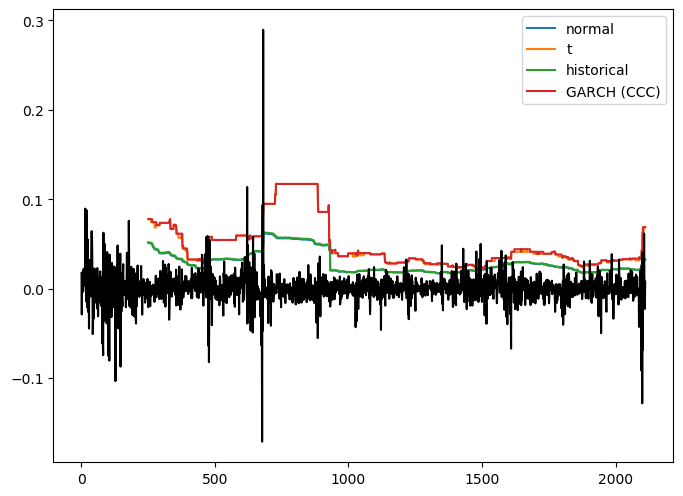

In [68]:
plt.figure(figsize=(8,6),dpi=100)
plt.plot(df.iloc[:,0],label='normal')
plt.plot(df.iloc[:,1],label='t')
plt.plot(df.iloc[:,2],label = 'historical')
plt.plot(df.iloc[:,3],label = 'GARCH (CCC)')
plt.plot(df_prices['portfolio_return'],'k')
#plt.ylim((-0.2,0.1))
plt.legend()

### Empirical 5- and 10-days VaRs

In [69]:
# latter four year
initial_investment = 1000000
four_year_data = df_prices.iloc[-1000:,:]
lookback = len(four_year_data)
df = 5
# 5-day VaR
df5=  four_year_data.groupby(np.arange(len(four_year_data))//5).sum()
df5.index= four_year_data.index[::5]
lookback5= lookback//5 # set lookback for 5 day VaR
# 10-day VaR   
df10= four_year_data.groupby(np.arange(len(four_year_data))//10).sum()
df10.index= four_year_data.index[::10]
lookback10= lookback//10 # set lookback for 10 day VaR

Methods= ["Normal", "Student-t", "Historical"]
Cols= ["5d_99","sq5d_99","10d_99","sq10d_99","5d_975","sq5d_975","10d_975","sq10d_975"]
dfEmpirical= pd.DataFrame(np.zeros((len(Methods),len(Cols))), index = Methods, columns= Cols)

alpha_x= np.array([0.01,0.025 ])                                  # Different confidences
lookback_x= np.array([lookback5, lookback, lookback10, lookback])   # Compare with sqrt time
df1= four_year_data.copy()
dfx= pd.DataFrame([df5, df1, df10, df1])
for i in range(len(alpha_x)):
    percent = [True,1-alpha_x[i]] 
    for j in range(len(lookback_x)):
        dfEmpirical.iloc[0,j+4*i], null= fnVaR_n(dfx.iloc[j,0], weights, alpha_x[i], lookback_x[j], percent,initial_investment)
        dfEmpirical.iloc[1,j+4*i], null= fnVaR_t(dfx.iloc[j,0], weights, lookback_x[j],df, alpha_x[i], percent, initial_investment)
        dfEmpirical.iloc[2,j+4*i], null= fnVaR_hist(dfx.iloc[j,0], weights, alpha_x[i], lookback_x[j], percent,initial_investment)
        #dfEmpirical.iloc[3,j+4*i], null= fnVaR_EWMA(dfx.iloc[j,0], weights, ewma_con, alpha_x[i], lookback_x[j], percent)
        if j == 1:
            dfEmpirical.iloc[:,j+4*i]= dfEmpirical.iloc[:,j+4*i]*np.sqrt(5)
        elif j == 3:
            dfEmpirical.iloc[:,j+4*i]= dfEmpirical.iloc[:,j+4*i]*np.sqrt(10)
# Convert output based on whether its df_prices.iloc[1:,:] or portfolio value
if percent[0] == False:
    dfEmpirical= (dfEmpirical*initial_investment).round(-1).astype(int)
else:
    dfEmpirical= (dfEmpirical*100).round(2)  
#dfEmpirical.to_csv("Tables/dfEmpiricalPercentages.csv", index_label= "Method")

( 99.0 %  VaR, ES) in percent is:  7.09 % 12.42 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  7.91 % 12.42 %
( 99.0 %  VaR, ES) in percent is:  17.17 % 18.01 %
( 99.0 %  VaR, ES) in percent is:  3.0 % 5.15 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.36 % 5.87 %
( 99.0 %  VaR, ES) in percent is:  8.06 % 10.97 %
( 99.0 %  VaR, ES) in percent is:  10.55 % 14.04 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  11.76 % 14.04 %
( 99.0 %  VaR, ES) in percent is:  23.61 % nan %
( 99.0 %  VaR, ES) in percent is:  3.0 % 5.15 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.36 % 5.87 %
( 99.0 %  VaR, ES) in percent is:  8.06 % 10.97 %
( 97.5 %  VaR, ES) in percent is:  6.02 % 10.9 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  6.11 % 10.9 %
( 97.5 %  VaR, ES) in percent is:  10.58 % 18.01 %
( 97.5 %  VaR, ES) in percent is:  2.54 % 4.27 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.58 % 4.35 %
( 97.5 %  VaR, ES) in percent is:  4.91 % 8.09 %
( 97.5 %  VaR, ES) in percent is:  8.97 % 14.04 %
DF= 5
( 97.5 %  VaR, E

/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [70]:
dfEmpirical

,5d_99,sq5d_99,10d_99,sq10d_99,5d_975,sq5d_975,10d_975,sq10d_975
Normal,7.09,6.71,10.55,9.49,6.02,5.67,8.97,8.02
Student-t,7.91,7.50,11.76,10.61,6.11,5.76,9.11,8.15
Historical,17.17,18.03,23.61,25.50,10.58,10.98,17.91,15.53


In [75]:
# first four years
initial_investment = 1000000
four_year_data = df_prices.iloc[1:-1000,:]
lookback = len(four_year_data)
df = 5
# 5-day VaR
df5=  four_year_data.groupby(np.arange(len(four_year_data))//5).sum()
df5.index= four_year_data.index[::5]
lookback5= lookback//5 # set lookback for 5 day VaR
# 10-day VaR   
df10= four_year_data.groupby(np.arange(len(four_year_data))//10).sum()
df10.index= four_year_data.index[::10]
lookback10= lookback//10 # set lookback for 10 day VaR

Methods= ["Normal", "Student-t", "Historical"]
Cols= ["5d_99","sq5d_99","10d_99","sq10d_99","5d_975","sq5d_975","10d_975","sq10d_975"]
dfEmpirical= pd.DataFrame(np.zeros((len(Methods),len(Cols))), index = Methods, columns= Cols)

alpha_x= np.array([0.01,0.025 ])                                  # Different confidences
lookback_x= np.array([lookback5, lookback, lookback10, lookback])   # Compare with sqrt time
df1= four_year_data.copy()
dfx= pd.DataFrame([df5, df1, df10, df1])
for i in range(len(alpha_x)):
    percent = [True,1-alpha_x[i]] 
    for j in range(len(lookback_x)):
        dfEmpirical.iloc[0,j+4*i], null= fnVaR_n(dfx.iloc[j,0], weights, alpha_x[i], lookback_x[j], percent,initial_investment)
        dfEmpirical.iloc[1,j+4*i], null= fnVaR_t(dfx.iloc[j,0], weights, lookback_x[j],df, alpha_x[i], percent, initial_investment)
        dfEmpirical.iloc[2,j+4*i], null= fnVaR_hist(dfx.iloc[j,0], weights, alpha_x[i], lookback_x[j], percent,initial_investment)
        #dfEmpirical.iloc[3,j+4*i], null= fnVaR_EWMA(dfx.iloc[j,0], weights, ewma_con, alpha_x[i], lookback_x[j], percent)
        if j == 1:
            dfEmpirical.iloc[:,j+4*i]= dfEmpirical.iloc[:,j+4*i]*np.sqrt(5)
        elif j == 3:
            dfEmpirical.iloc[:,j+4*i]= dfEmpirical.iloc[:,j+4*i]*np.sqrt(10)
# Convert output based on whether its df_prices.iloc[1:,:] or portfolio value
if percent[0] == False:
    dfEmpirical= (dfEmpirical*initial_investment).round(-1).astype(int)
else:
    dfEmpirical= (dfEmpirical*100).round(2)  
#dfEmpirical.to_csv("Tables/dfEmpiricalPercentages.csv", index_label= "Method")

( 99.0 %  VaR, ES) in percent is:  11.93 % 14.58 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  13.32 % 15.07 %
( 99.0 %  VaR, ES) in percent is:  22.63 % nan %
( 99.0 %  VaR, ES) in percent is:  4.81 % 7.41 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.38 % 7.95 %
( 99.0 %  VaR, ES) in percent is:  11.67 % 17.09 %
( 99.0 %  VaR, ES) in percent is:  18.94 % 30.51 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  21.12 % 30.51 %
( 99.0 %  VaR, ES) in percent is:  33.44 % nan %
( 99.0 %  VaR, ES) in percent is:  4.81 % 7.41 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.38 % 7.95 %
( 99.0 %  VaR, ES) in percent is:  11.67 % 17.09 %
( 97.5 %  VaR, ES) in percent is:  10.12 % 13.51 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  10.27 % 13.51 %
( 97.5 %  VaR, ES) in percent is:  13.75 % 15.62 %
( 97.5 %  VaR, ES) in percent is:  4.06 % 6.6 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.13 % 6.72 %
( 97.5 %  VaR, ES) in percent is:  6.4 % 9.21 %
( 97.5 %  VaR, ES) in percent is:  16.09 % 30.51 %
DF= 5
( 97.5 % 

/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [74]:
dfEmpirical

,5d_99,sq5d_99,10d_99,sq10d_99,5d_975,sq5d_975,10d_975,sq10d_975
Normal,11.93,10.75,18.94,15.20,10.12,9.09,16.09,12.85
Student-t,13.32,12.02,21.12,17.00,10.27,9.23,16.33,13.05
Historical,22.63,26.10,33.44,36.91,13.75,14.31,24.27,20.24


**12.04 Pan**<br>
The histogram and QQ-plot are not functioning due to some undefined functions, maybe you can have a look :) <br> **AM**: fixed <br>
I still left out the bond one, you can add it into it!
I added the price return and exchange rate return together to form a new return which includes the FX exposure,
and I think it's correct. If it's wrong please let me know! <br> **13.04 AM:**:  <br> 
1/FX seems correct to me (I see you used the formula from the last lecture) <br>
2/About the bond - fixed some issues to integrate the data with the rest of the datasets. For now, I calculated the return as simple difference between current and lagged price. We can add to our list of questions to see if we should do it differently.. <br>
3/Added EWMA <br>
3/Added some plots <br>
4/Stress testing: Added calculations on stressed returns for the stocks, but with my very poor python skills it's ugly :(  <br>
<br>
**To-do:**
1. GARCH(1,1) using CCC **((done))** <br> 
2. Sensitivity Analysis <br>
Investigate the sensitivity of your results to the length of the estimation period, i.e., estimate the variance-covariance matrix based on different past periods and compare the resulting VaR and ES estimates. Especially investigate the differences when you do and do not include stressed periods. - maybe we can compare January February and March this year (covid crisis) to the previous quarters? **((done))**<br>
3. Backtesting <br>
Backtest your VaR systems outlined above, by comparing the expected and the actual number of VaR violations per year and the average discrepancy between these two over all years. Also compare the expected shortfalls with average (per year) shortfalls. Plot the VaR violations against the time to investigate whether VaR violations occurred in clusters (indicating dependency between violations) or were evenly spread out in time. <br>
**((Half way- EWMA with filtered historical simulation needs to be changed to a function)**
4. Compute empirical 5- and 10-days VaRs using historical simulation method (use non-overlapping data!), compare them to the VaRs obtained from the one-day VaR with the square root of time rule and assess the adequacy of this rule applied to your portfolio. **((done))** <br>
**The values are strange, I will have a look later.**

5. Stress Testing <br> Complement your VaR system with stress testing, where you let extreme scenarios happen to your main risk factors. Use the following guidelines to generate extreme scenarios (use separate scenarios for risk factors, so not combinations of these):
    - Equity index values or stock prices changing by +/- 20% and +/- 40% of the current values (portfolio returns done)
    - Currencies moving by +/- 10% for major currencies and +/- 20% for other currencies.
    - Commodity prices changing by +/- 20% and +/-40% of the current values.
    - Interest rates shifting by +/- 2% and +/- 3%.

**Discussion ((Pan))** <br>
1. For the bond, do we need to consider the exchange rate? <br>
    I have a look on how yield is calculated, and seems like the FX are cancelled.
    So I think we actually don't need to add into the portfolio, but not sure.
2. For both Garch and EWMA, since we are using conditional variance, do we need to seperate the return 
    of FX and asset? I suppose we will calculate their return seperately and combine??
    Really confused, we should ask!! What do you think?
    
I will try to fix the problem of EWMA ASAP and maybe you can check if the rest makes sense!
Oh and we can discuss also what to put into the report.
I think the last year's is good but it's a lot to write!

Check the correlation between assets

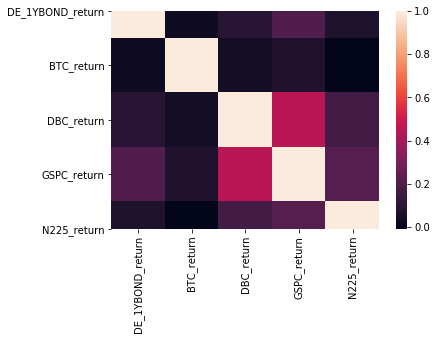

In [152]:
import seaborn as sns
returns = data[['DE_1YBOND_return',"BTC_return", "DBC_return", "GSPC_return", "N225_return"]]

corr = returns.corr()
sns.heatmap(corr)